### Import depdencies

In [1]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

from torchsample.modules import ModuleTrainer

from torchsample.callbacks import EarlyStopping
from torchsample.regularizers import L1Regularizer

from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch
import time

from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import warnings

pd.set_option('max_column', 0)
warnings.filterwarnings('ignore')

from full_data_load_ep import *
from data_processing import *
# from data_model import *

import joblib

In [2]:
# load database credentials and create connection
user, password, server, database, port = load_db_credentials()
engine = create_engine(f'postgresql://{user}:{password}@{server}:{port}/{database}')

### Data Processing

In [18]:
print('--- Reading Data From Database ---')
# read data in from database
query = open('player_stats.sql', 'r').read()

skaters = pd.read_sql(query, engine)
team_stats = pd.read_sql(''' select * from team_stats  ''', engine)
info = pd.read_sql(''' select * from player_info ''', engine)

print('--- Engineering features ---')

# merge player information with player seasons
skaters = skaters.merge(info[info.date_of_birth.notnull()].drop('position', axis=1), on = ['playerid'])


--- Reading Data From Database ---
--- Engineering features ---


In [4]:
# era adjust scoring
scoring = skaters.groupby(['league', 'year']).g.sum() / \
            skaters.groupby(['league', 'year']).gp.sum()

scoring = scoring.rename('deflator').to_frame()

scoring = scoring.merge(scoring[scoring.index.get_level_values('year') == '2019-2020'],
              on='league',
              suffixes=('', '_base'),
              how='left').set_index(scoring.index)

scoring['deflator'] /= scoring['deflator_base']

skaters = skaters.merge(scoring, on = ['league', 'year'])
# df = pd.read_sql('''select 
# 	league,
# 	year,
# 	sum(g) as g,
# 	max(gp) as gp,
# 	count(distinct teamid) teams,
# 	sum(g) / (max(gp) * count(distinct teamid)) as goals_per_game
# from skater_stats ss 
# where season_stage not like '%ET%'
# and season_stage not like '%Cup%'
# and season_stage not like '%JCWC%'
# and season_stage not like '%PJHL%'
# and season_stage not like '%Czech U16 2%' 
# and season_stage not like '%Showcase%'
# and season_stage not like '%ECC%'
# and season_stage not like '% Q'
# and season_stage not like 'MHL Supercup'
# group by 
# 1
# ,2
# having max(gp) * count(distinct teamid) > 15
# ;
# ''', engine)


# scoring = df.merge(df[df['year'] == '2019-2020'][['league', 'goals_per_game']],
#               on='league',
#               suffixes=('', '_base'),
#               how='left')

# scoring['deflator']  = scoring['goals_per_game'] / scoring['goals_per_game_base']

# skaters = skaters.merge(scoring[['league', 'year', 'deflator']], on = ['league', 'year'])

skaters['tp'] /= skaters.deflator
skaters['g'] /= skaters.deflator
skaters['a'] /= skaters.deflator
skaters['gpg'] /= skaters.deflator
skaters['apg'] /= skaters.deflator
skaters['ppg'] /= skaters.deflator

# get season age per player season
skaters['start_year'], skaters['end_year']  = zip(*skaters['year'].apply(lambda x : x.split('-')))
skaters = get_season_age(skaters)

# return player season with one league played per 
# year. Choose league where player played most games
df = collapse_player_league_seasons(skaters)

# save results to csv

In [5]:
df.to_csv('../../apple-model-app/data/player_season_stats_v3.csv')

In [6]:
df.to_csv('../data/player_season_stats_v3.csv')

### NN Data Loader

In [3]:
df = pd.read_csv('../data/player_season_stats_v3.csv')

X, y,_ = prepare_features(df, 'ppg_y_plus_1')

players = X.index.droplevel(-1).unique() # get number indices
n_players = players.shape[0] # get number of players
train_idx, test_idx = train_test_split(players, test_size=0.3, random_state=18)

print('--- Padding Player Data ---')

X = pad_data(X.reset_index(), players)
y = pad_data(y.reset_index(), players)

X.set_index(['playerid', 'player', 'season_age'], inplace=True)
y.set_index(['playerid', 'player', 'season_age'], inplace=True)

print('--- Generating Player Data ---')
train_seq, train_target = generate_players(X, y, train_idx)
test_seq, test_target = generate_players(X, y, test_idx)

train_idx_bool = pd.Series(list(X.index.droplevel(-1))).isin(train_idx).values
test_idx_bool = pd.Series(list(X.index.droplevel(-1))).isin(test_idx).values

train_real_values = (X[train_idx_bool] != -1).all(axis=1)
test_real_values = (X[test_idx_bool] != -1).all(axis=1)

seasons, performance = generate_players(X, y, players)

--- Padding Player Data ---
--- Generating Player Data ---


In [6]:
m = joblib.load('../models/baseline_scoring_13-09-2020.pkl')

In [10]:
baseline_preds = pd.concat([
    X[train_idx_bool][train_real_values].assign(
        pred_ppg=m.predict(X[train_idx_bool][train_real_values]),
        next_ppg=y[train_idx_bool][train_real_values],
        sample='train_set'
    ),
    X[test_idx_bool][test_real_values].assign(
        pred_ppg=m.predict(X[test_idx_bool][test_real_values]),
        next_ppg=y[test_idx_bool][test_real_values],
        sample='test_set')
]).reset_index()

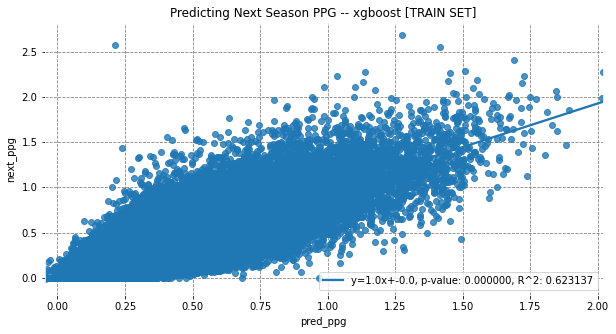

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.style as style

plt.rc('axes', facecolor='#ffffff', edgecolor='#ffffff',
       axisbelow=True, grid=True,
      )
plt.rc('grid', color='grey', linestyle='dashed')
plt.rc('patch', edgecolor='#ffffff', facecolor='#ffffff')

plt.figure(figsize=(10,5),facecolor="#ffffff")

slope, intercept, r_value, p_value, std_err = stats.linregress(baseline_preds[baseline_preds['sample'] == 'train_set'].pred_ppg,
                                                               baseline_preds[baseline_preds['sample'] == 'train_set'].next_ppg)

sns.regplot(data = baseline_preds[baseline_preds['sample'] == 'train_set'], 
               x = 'pred_ppg',
                y = 'next_ppg',
               line_kws={'label':"y={0:.1f}x+{1:.1f}, p-value: {2:2f}, R^2: {3:2f}".format(slope,
                                                                                           intercept,
                                                                                           p_value, 
                                                                                           r_value ** 2)})
plt.title('Predicting Next Season PPG -- xgboost [TRAIN SET]')
plt.legend()
plt.show()

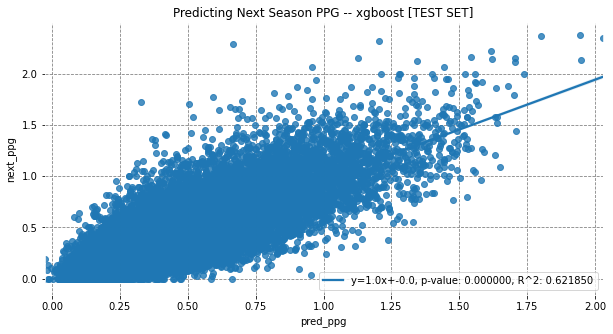

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.style as style

plt.rc('axes', facecolor='#ffffff', edgecolor='#ffffff',
       axisbelow=True, grid=True,
      )
plt.rc('grid', color='grey', linestyle='dashed')
plt.rc('patch', edgecolor='#ffffff', facecolor='#ffffff')

plt.figure(figsize=(10,5),facecolor="#ffffff")

slope, intercept, r_value, p_value, std_err = stats.linregress(baseline_preds[baseline_preds['sample'] == 'test_set'].pred_ppg,
                                                               baseline_preds[baseline_preds['sample'] == 'test_set'].next_ppg)

sns.regplot(data = baseline_preds[baseline_preds['sample'] == 'test_set'], 
               x = 'pred_ppg',
                y = 'next_ppg',
               line_kws={'label':"y={0:.1f}x+{1:.1f}, p-value: {2:2f}, R^2: {3:2f}".format(slope,
                                                                                           intercept,
                                                                                           p_value, 
                                                                                           r_value ** 2)})
plt.title('Predicting Next Season PPG -- xgboost [TEST SET]')
plt.legend()
plt.show()

In [15]:
baseline_preds[baseline_preds.player == 'Elias Pettersson']

,playerid,player,season_age,forward,gp,gp_y_plus_1,draft_pick,is_drafted,height,weight,real_season_age,gpg,apg,ppg,perc_team_g,perc_team_a,perc_team_tp,AJHL,Allsvenskan,BCHL,CCHL,Czech,Czech2,Jr. A SM-liiga,KHL,Liiga,MHL,NCAA,NHL,NLA,OHL,OJHL,QMJHL,SHL,SJHL,SuperElit,USHL,VHL,WHL,18,19,20,21,22,23,round_1.0,round_2.0,round_3.0,round_4.0,round_5.0,round_6.0,round_7.0,round_8.0,round_9.0,next_yr_AJHL,next_yr_Allsvenskan,next_yr_BCHL,next_yr_CCHL,next_yr_Czech,next_yr_Czech2,next_yr_Jr. A SM-liiga,next_yr_KHL,next_yr_Liiga,next_yr_MHL,next_yr_NCAA,next_yr_NHL,next_yr_NLA,next_yr_OHL,next_yr_OJHL,next_yr_QMJHL,next_yr_SHL,next_yr_SJHL,next_yr_SuperElit,next_yr_USHL,next_yr_VHL,next_yr_WHL,pred_ppg,next_ppg,sample
23290,266336,Elias Pettersson,18.0,1.0,0.202703,0.375000,0.000000,0.0,0.66,0.184397,0.14,0.080000,0.133333,0.141000,0.112069,0.118056,0.125506,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.458242,0.953488,train_set
23291,266336,Elias Pettersson,19.0,1.0,0.445946,0.511364,0.000000,0.0,0.66,0.184397,0.14,0.294574,0.284238,0.373450,0.381466,0.237847,0.309717,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.560097,1.181818,train_set
23292,266336,Elias Pettersson,20.0,1.0,0.608108,0.693182,0.017182,1.0,0.66,0.184397,0.13,0.363636,0.353535,0.462879,0.364224,0.213194,0.284615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.618026,0.929577,train_set
23293,266336,Elias Pettersson,21.0,1.0,0.824324,0.659091,0.017182,1.0,0.66,0.184397,0.13,0.262911,0.297340,0.364085,0.318966,0.217014,0.269231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.739455,0.970588,train_set


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
train_counts = pd.DataFrame(
    X[train_idx_bool][train_real_values][sorted(df.league.unique())[1:]].idxmax(axis=1),
    columns=['league']).reset_index()\
.groupby('league').agg(
    {'player' : 'count'}
).rename(columns={'player' : '% of sample'})

train_pct = train_counts.div(train_counts.sum())

test_counts = pd.DataFrame(
    X[test_idx_bool][test_real_values][sorted(df.league.unique())[1:]].idxmax(axis=1),
    columns=['league']).reset_index()\
.groupby('league').agg(
    {'player' : 'count'}
).rename(columns={'player' : '% of sample'})

test_pct = test_counts.div(test_counts.sum())

In [8]:
league_dist = train_pct.merge(test_pct, left_index=True, right_index=True, suffixes=(' [TRAIN]', ' [TEST]'))


<Figure size 720x1440 with 0 Axes>

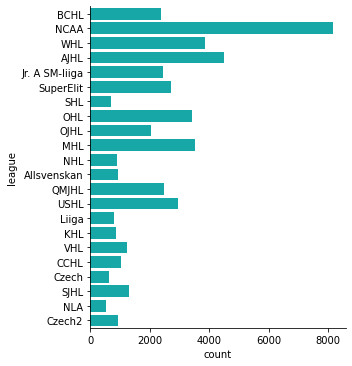

In [9]:
plt.figure(figsize=(10, 20))

ax = sns.catplot(data=pd.DataFrame(
    X[train_idx_bool][train_real_values][sorted(df.league.unique())[1:]].idxmax(axis=1),
    columns=['league']).reset_index(),
            y='league',
            color='c',
            kind="count")

plt.show()

Text(0, 0.5, 'League')

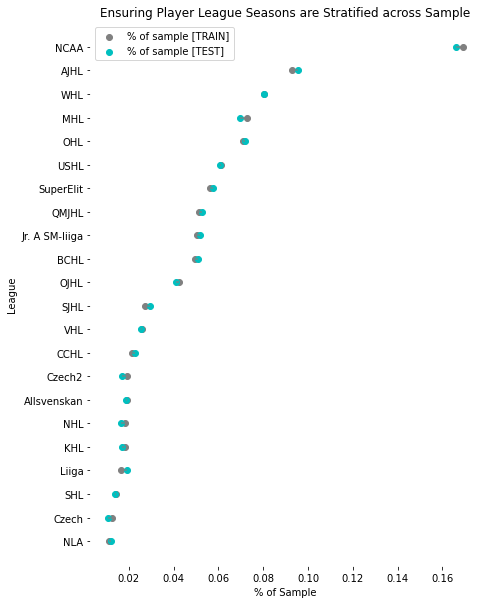

In [10]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('axes', facecolor='#ffffff', edgecolor='#ffffff',
       axisbelow=True
      )

plt.figure(figsize=(7, 10))

# Create a dataframe
df = league_dist.reset_index()
 
# Reorder it following the values of the first value:
ordered_df = df.sort_values(by="% of sample [TRAIN]")
my_range=range(1,len(df.index)+1)
 
# The vertical plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
plt.hlines(y=my_range,
           xmin=ordered_df["% of sample [TRAIN]"],
           xmax=ordered_df["% of sample [TEST]"], 
           color='grey',
           alpha=0.8)

plt.scatter(ordered_df["% of sample [TRAIN]"],
            my_range, 
            color='grey', 
            alpha=1, 
            label="% of sample [TRAIN]")

plt.scatter(ordered_df["% of sample [TEST]"],
            my_range, 
            color='c', 
            alpha=1 , 
            label="% of sample [TEST]")
plt.legend()
 
# Add title and axis names
plt.yticks(my_range, ordered_df['league'])
plt.title("Ensuring Player League Seasons are Stratified across Sample")
plt.xlabel('% of Sample')
plt.ylabel('League')


### Baseline Model xgboost

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

baseline = XGBRegressor()



baseline.fit(X[train_idx_bool][train_real_values], y[train_idx_bool][train_real_values])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
params = [{'max_depth': [4, 5, 6, 8],
           'learning_rate': [1e-1, 0.2],
           'n_estimators': [250, 300 ,350, 400, 500]}]

gridsearch = GridSearchCV(estimator=XGBRegressor(),
                          param_grid=params,
                          n_jobs=6,
                          cv=5,
                          verbose=25,
                          scoring= 'neg_log_loss',
                          return_train_score=True,
                          )


gridsearch.fit(X=X[train_idx_bool][train_real_values],
               y=y[train_idx_bool][train_real_values])

print(gridsearch.best_params_)

m = gridsearch.best_estimator_.fit(X[train_idx_bool][train_real_values], 
                                   y=y[train_idx_bool][train_real_values])

In [10]:
print('[TRAIN SET] Baseline xgboost Mean Absolute Error: {:2f}'.format(mean_absolute_error(
    y[train_idx_bool][train_real_values],
    baseline.predict(X[train_idx_bool][train_real_values]))
                                                          )
     )

print('[TRAIN SET] Baseline xgboost Mean Squared Error: {:2f}'.format(mean_squared_error(
    y[train_idx_bool][train_real_values],
    baseline.predict(X[train_idx_bool][train_real_values]))
                                                          )
     )

[TRAIN SET] Baseline xgboost Mean Absolute Error: 0.134091
[TRAIN SET] Baseline xgboost Mean Squared Error: 0.030811


In [11]:
print('[TEST SET] Baseline xgboost Mean Absolute Error: {:2f}'.format(mean_absolute_error(
    y[test_idx_bool][test_real_values],
    baseline.predict(X[test_idx_bool][test_real_values]))
                                                          )
     )

print('[TEST SET] Baseline xgboost Mean Squared Error: {:2f}'.format(mean_squared_error(
    y[test_idx_bool][test_real_values],
    baseline.predict(X[test_idx_bool][test_real_values]))
                                                          )
     )

[TEST SET] Baseline xgboost Mean Absolute Error: 0.157136
[TEST SET] Baseline xgboost Mean Squared Error: 0.043510


In [13]:
import shap

# load JS visualization code to notebook
shap.initjs()
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(baseline)
shap_values = explainer.shap_values(X[train_idx_bool][train_real_values])
# summarize the effects of all the features

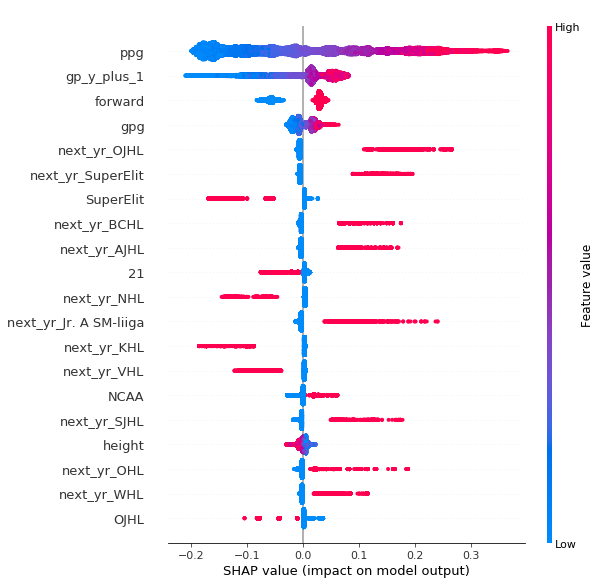

In [8]:
shap.summary_plot(shap_values, X[train_idx_bool][train_real_values])

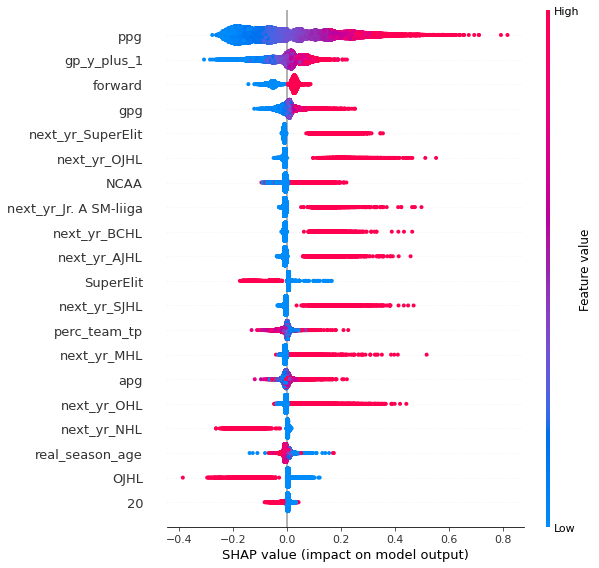

In [14]:
shap.summary_plot(shap_values, X[train_idx_bool][train_real_values])

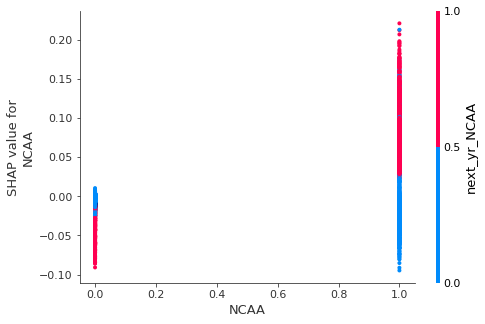

In [16]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("NCAA", shap_values, X[train_idx_bool][train_real_values])

In [17]:
baseline_preds = pd.concat([
    X[train_idx_bool][train_real_values].assign(
        pred_ppg=baseline.predict(X[train_idx_bool][train_real_values]),
        next_ppg=y[train_idx_bool][train_real_values],
        sample='train_set'
    ),
    X[test_idx_bool][test_real_values].assign(
        pred_ppg=baseline.predict(X[test_idx_bool][test_real_values]),
        next_ppg=y[test_idx_bool][test_real_values],
        sample='test_set')
]).reset_index()

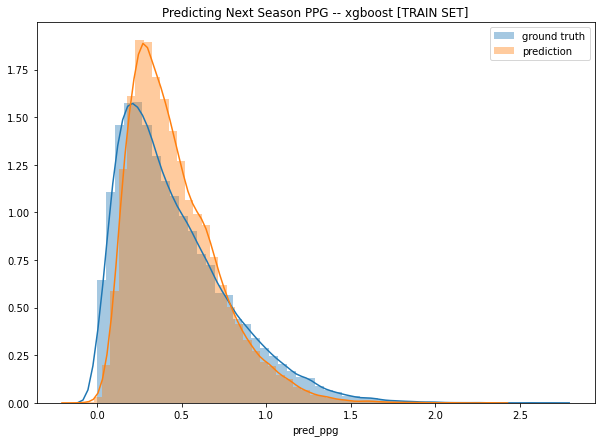

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
sns.distplot(baseline_preds[baseline_preds['sample'] == 'train_set'].next_ppg, label='ground truth')
sns.distplot(baseline_preds[baseline_preds['sample'] == 'train_set'].pred_ppg, label='prediction')
plt.legend()
plt.title('Predicting Next Season PPG -- xgboost [TRAIN SET]')
plt.show()

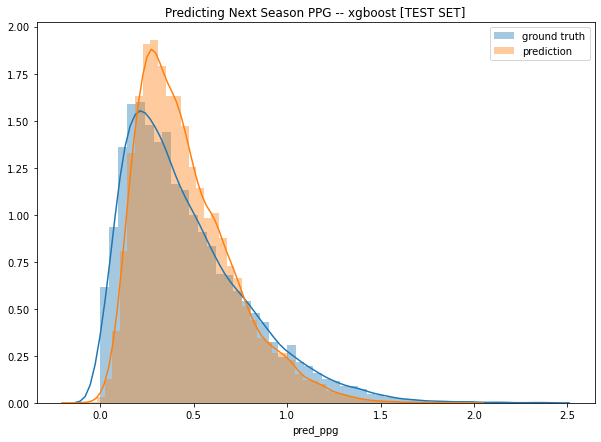

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
sns.distplot(baseline_preds[baseline_preds['sample'] == 'test_set'].next_ppg, label='ground truth')
sns.distplot(baseline_preds[baseline_preds['sample'] == 'test_set'].pred_ppg, label='prediction')
plt.legend()
plt.title('Predicting Next Season PPG -- xgboost [TEST SET]')
plt.show()

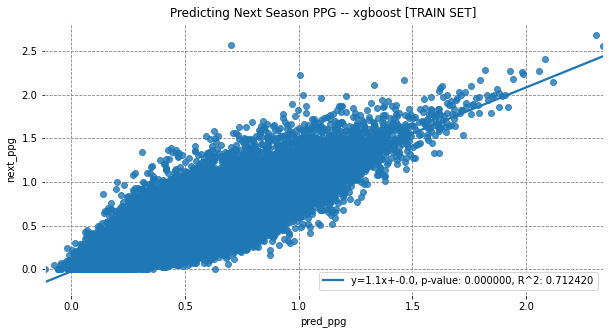

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.style as style

plt.rc('axes', facecolor='#ffffff', edgecolor='#ffffff',
       axisbelow=True, grid=True,
      )
plt.rc('grid', color='grey', linestyle='dashed')
plt.rc('patch', edgecolor='#ffffff', facecolor='#ffffff')

plt.figure(figsize=(10,5),facecolor="#ffffff")

slope, intercept, r_value, p_value, std_err = stats.linregress(baseline_preds[baseline_preds['sample'] == 'train_set'].pred_ppg,
                                                               baseline_preds[baseline_preds['sample'] == 'train_set'].next_ppg)

sns.regplot(data = baseline_preds[baseline_preds['sample'] == 'train_set'], 
               x = 'pred_ppg',
                y = 'next_ppg',
               line_kws={'label':"y={0:.1f}x+{1:.1f}, p-value: {2:2f}, R^2: {3:2f}".format(slope,
                                                                                           intercept,
                                                                                           p_value, 
                                                                                           r_value ** 2)})
plt.title('Predicting Next Season PPG -- xgboost [TRAIN SET]')
plt.legend()
plt.show()



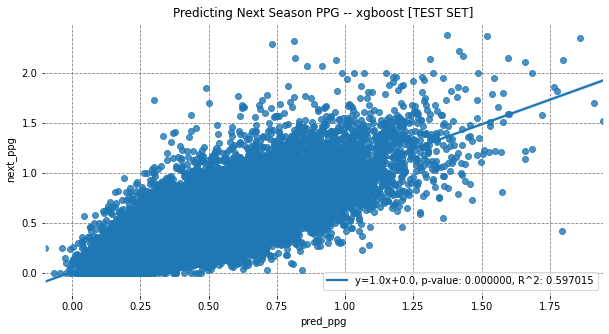

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.style as style

plt.rc('axes', facecolor='#ffffff', edgecolor='#ffffff',
       axisbelow=True, grid=True,
      )
plt.rc('grid', color='grey', linestyle='dashed')
plt.rc('patch', edgecolor='#ffffff', facecolor='#ffffff')

plt.figure(figsize=(10,5),facecolor="#ffffff")

slope, intercept, r_value, p_value, std_err = stats.linregress(baseline_preds[baseline_preds['sample'] == 'test_set'].pred_ppg,
                                                               baseline_preds[baseline_preds['sample'] == 'test_set'].next_ppg)

sns.regplot(data = baseline_preds[baseline_preds['sample'] == 'test_set'], 
               x = 'pred_ppg',
                y = 'next_ppg',
               line_kws={'label':"y={0:.1f}x+{1:.1f}, p-value: {2:2f}, R^2: {3:2f}".format(slope,
                                                                                           intercept,
                                                                                           p_value, 
                                                                                           r_value ** 2)})
plt.title('Predicting Next Season PPG -- xgboost [TEST SET]')
plt.legend()
plt.show()

In [5]:


joblib.dump(baseline, 'scoring_model.pkl')

### LSTM Model 

In [4]:
class Model(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, lstm_layers=2, output_size=1, drop=0.1):
        
        super().__init__()
        self.start = time.time()
        self.hidden_size = hidden_size
        self.lstm_layers = lstm_layers
        self.lstm = nn.LSTM(input_size, hidden_size, lstm_layers, batch_first=True,
#                             dropout=drop
                           )
        self.linear = nn.Linear(hidden_size, output_size)  
        self.relu = nn.ReLU()

    def forward(self, seasons):

        ht = torch.zeros(self.lstm_layers, 1, self.hidden_size)   # initialize hidden state
        ct = torch.zeros(self.lstm_layers, 1, self.hidden_size)  # initialize cell state
        predictions = torch.Tensor([]) # to store our predictions for season t+1
        
        hidden = (ht, ct)
        
        for idx, season in enumerate(seasons):  # here we want to iterate over the time dimension
            lstm_input = torch.FloatTensor(season).view(1,1,len(season)) # LSTM takes 3D tensor
            out, hidden = self.lstm(lstm_input, hidden) # LSTM updates hidden state and returns output
            pred_t = self.linear(out) # pass LSTM output through a linear activation function
            pred_t = self.relu(pred_t) # since performance is non-negative we apply ReLU
            
            predictions = torch.cat((predictions, pred_t)) # concatenate all the predictions

        return predictions

class Trainer(object):
    def __init__(self, train_sequences, train_targets, test_sequences, test_targets, model, epochs=200, lr=0.01, batch_size=1, log_per=10000):
        self.start = time.time()
        self.epochs = epochs
        self.log_per = log_per
        self.train_sequences = train_sequences
        self.train_targets = train_targets
        self.test_sequences = test_sequences
        self.test_targets = test_targets
        self.batch_size = batch_size
        self.lr = lr
        self.loss_fn = nn.MSELoss()
        self.model = model
        
    def train(self):

        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr,
                                     weight_decay=1e-6
                                    )
        
         # to track the average training loss per epoch as the model trains
        avg_train_losses = []
        # to track the average validation loss per epoch as the model trains
        avg_valid_losses = [] 

        # Training of the model.
        self.model.train()
        for epoch in range(self.epochs):

            train_loss = []
            test_loss = []
            print(f'Running epoch: {epoch}')
            for seasons, targets in zip(self.train_sequences, self.train_targets): # data is a list returning tuple of X, y

                optimizer.zero_grad()

                mask = torch.tensor([(season > -1).all() for season in seasons]) # create mask for real seasons only      
                targets = torch.FloatTensor(targets)[mask]

                predictions = self.model(seasons)    
                # now here, we want to compute the loss between the predicted values
                # for each season and the actual values for each season
                # TO-DO: random select grouth truth or predicted value in next timestep
                loss = self.loss_fn(predictions[mask].squeeze(1), targets) 
                loss.backward()
                optimizer.step() 
                train_loss.append(loss.item())

            avg_train_losses.append(np.nanmean(train_loss))
        
            if epoch%10 == 0:
                # validate with test set
                self.model.eval()
                with torch.no_grad():
                    for seasons, targets in zip(self.test_sequences, self.test_targets):
                        mask = torch.tensor([(season > -1).all() for season in seasons]) # create mask for real seasons only      
                        targets = torch.FloatTensor(targets)[mask]

                        predictions = self.model(seasons)    
                        # now here, we want to compute the loss between the predicted values
                        # for each season and the actual values for each season
                        # TO-DO: random select grouth truth or predicted value in next timestep
                        loss = self.loss_fn(predictions[mask].squeeze(1), targets) 
                        test_loss.append(loss.item())

                avg_valid_losses.append(np.nanmean(test_loss))
        
        print(f'epoch: {epoch} train avg. loss: {np.nanmean(avg_train_losses):10.8f}')
        print(f'epoch: {epoch} test loss: {np.nanmean(avg_valid_losses):10.8f}')

        print(f'Total Model Training Runtime: {(time.time() - self.start)//60:10.8f} mins')
        self.train_loss = avg_train_losses
        self.test_loss = avg_valid_losses   


In [5]:
input_size = X.shape[1]
output_size = 1
hidden_size = X.shape[1] * 2

model = Model(input_size=input_size, output_size=output_size, hidden_size=hidden_size, lstm_layers=2)

In [11]:
# train model using train / test split
trainer = Trainer(train_seq,
                  train_target,
                  test_seq,
                  test_target,
                  model,
                  epochs=20, 
                  lr=0.001) # best run: {'epochs' : 50, 'lr' : 50}
trainer.train()

Running epoch: 0
Running epoch: 1
Running epoch: 2
Running epoch: 3
Running epoch: 4
Running epoch: 5
Running epoch: 6
Running epoch: 7
Running epoch: 8
Running epoch: 9
Running epoch: 10
Running epoch: 11
Running epoch: 12
Running epoch: 13
Running epoch: 14
Running epoch: 15
Running epoch: 16
Running epoch: 17
Running epoch: 18
Running epoch: 19
epoch: 19 train avg. loss: 0.03688524
epoch: 19 test loss: 0.04030951
Total Model Training Runtime: 80.00000000 mins


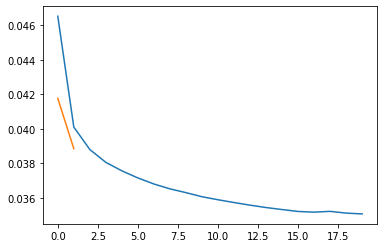

In [12]:
import matplotlib.pyplot as plt 

plt.Figure(figsize=(20,14))
plt.plot(trainer.train_loss)
plt.plot(trainer.test_loss)
plt.show()

In [179]:
name = f'../models/scoring_lstm_2_0.pth'

torch.save(model.state_dict(), name)

In [6]:
def bootstrap_training(train_idx, test_idx, version):
    
    model = Model(input_size=input_size, output_size=output_size, hidden_size=hidden_size, lstm_layers=2)
    
    trainer = Trainer([seasons[i] for i in train_idx], 
                      [performance[i] for i in train_idx],
                      [seasons[i] for i in test_idx],
                      [performance[i] for i in test_idx],
                      model,
                      epochs=20, 
                      lr=0.001) # best run: {'epochs' : 50, 'lr' : 50}
    trainer.train()
    
    name = f'../models/v2_boot_lstm_{version}.pth'
    torch.save(trainer.model.state_dict(), name)
    
    plt.Figure(figsize=(20,14))
    plt.plot(trainer.train_loss)
    plt.plot(trainer.test_loss)
    plt.show()

In [7]:
import matplotlib.pyplot as plt 
from multiprocessing import Pool

from sklearn.model_selection import ShuffleSplit

# randomly shuffle / split player seasons
ss = ShuffleSplit(n_splits=100, test_size=0.75, random_state=42)
bootstrap = ss.split(players)

Running epoch: 0
Running epoch: 0
Running epoch: 0
Running epoch: 0
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 14
Running epoch:

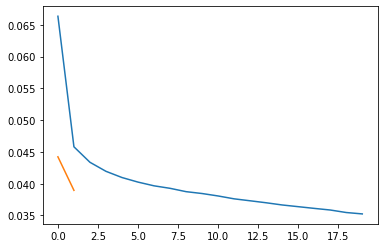

Running epoch: 0
epoch: 19 train avg. loss: 0.03845037
epoch: 19 test loss: 0.04321029
Total Model Training Runtime: 74.00000000 mins


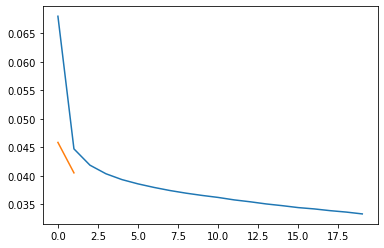

Running epoch: 0
epoch: 19 train avg. loss: 0.03839690
epoch: 19 test loss: 0.04204236
Total Model Training Runtime: 74.00000000 mins
epoch: 19 train avg. loss: 0.03940704
epoch: 19 test loss: 0.04462580
Total Model Training Runtime: 74.00000000 mins


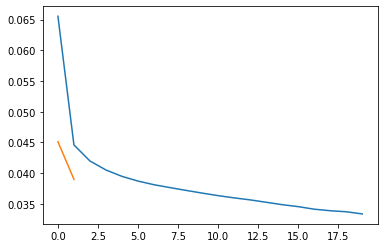

Running epoch: 0


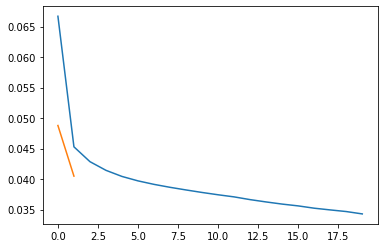

Running epoch: 0
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epo

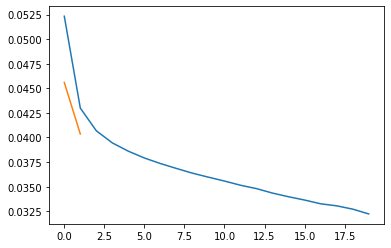

Running epoch: 0
epoch: 19 train avg. loss: 0.03811697
epoch: 19 test loss: 0.04336780
Total Model Training Runtime: 65.00000000 mins


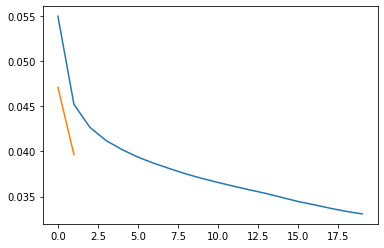

Running epoch: 0
epoch: 19 train avg. loss: 0.03805923
epoch: 19 test loss: 0.04252915
Total Model Training Runtime: 65.00000000 mins


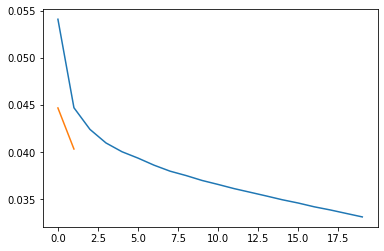

Running epoch: 0
epoch: 19 train avg. loss: 0.03697681
epoch: 19 test loss: 0.04208665
Total Model Training Runtime: 65.00000000 mins


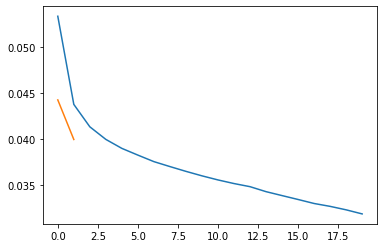

Running epoch: 0
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epo

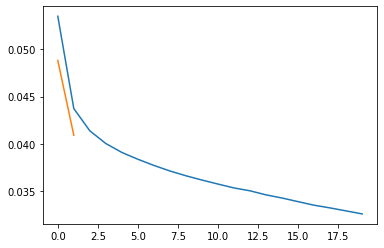

Running epoch: 0
epoch: 19 train avg. loss: 0.03745623
epoch: 19 test loss: 0.04226098
Total Model Training Runtime: 68.00000000 mins


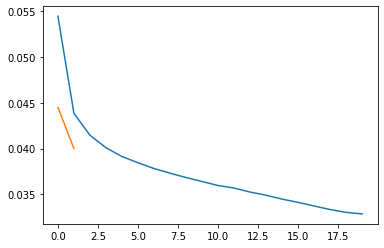

Running epoch: 0
epoch: 19 train avg. loss: 0.03804704
epoch: 19 test loss: 0.04181115
Total Model Training Runtime: 68.00000000 mins


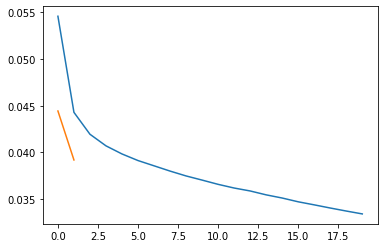

Running epoch: 0
epoch: 19 train avg. loss: 0.03772992
epoch: 19 test loss: 0.04571979
Total Model Training Runtime: 68.00000000 mins


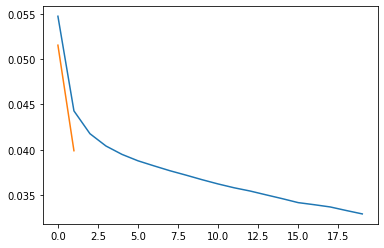

Running epoch: 0
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epo

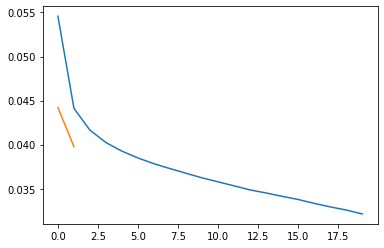

Running epoch: 0
epoch: 19 train avg. loss: 0.03865344
epoch: 19 test loss: 0.04090341
Total Model Training Runtime: 77.00000000 mins


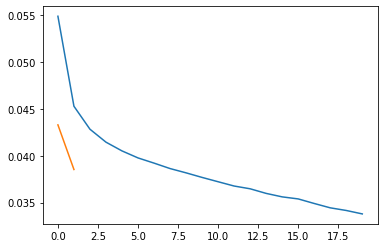

Running epoch: 0
epoch: 19 train avg. loss: 0.03796297
epoch: 19 test loss: 0.04216406
Total Model Training Runtime: 77.00000000 mins


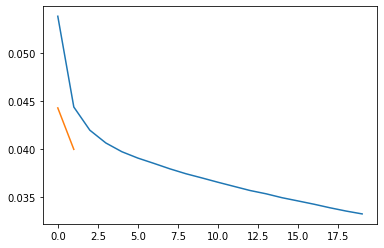

Running epoch: 0
epoch: 19 train avg. loss: 0.03705432
epoch: 19 test loss: 0.04996934
Total Model Training Runtime: 77.00000000 mins


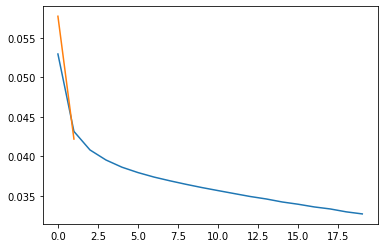

Running epoch: 0
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epo

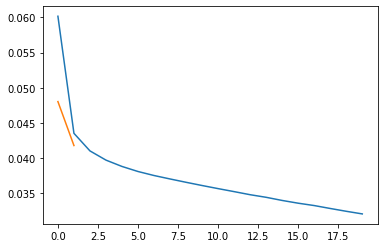

Running epoch: 0
epoch: 19 train avg. loss: 0.03923305
epoch: 19 test loss: 0.04369620
Total Model Training Runtime: 69.00000000 mins


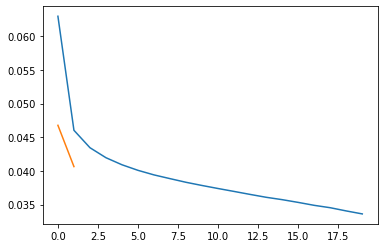

Running epoch: 0
epoch: 19 train avg. loss: 0.03978928
epoch: 19 test loss: 0.04299496
Total Model Training Runtime: 69.00000000 mins


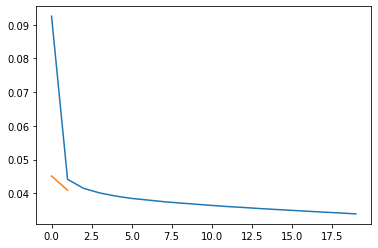

Running epoch: 0
epoch: 19 train avg. loss: 0.03898649
epoch: 19 test loss: 0.04311103
Total Model Training Runtime: 69.00000000 mins


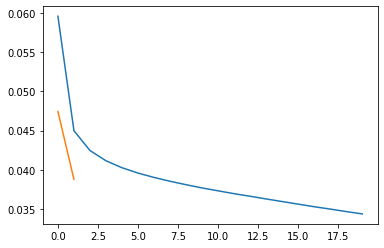

Running epoch: 0
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epo

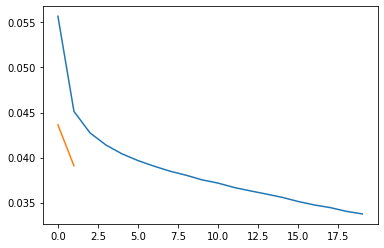

Running epoch: 0
epoch: 19 train avg. loss: 0.03728958
epoch: 19 test loss: 0.04307520
Total Model Training Runtime: 70.00000000 mins


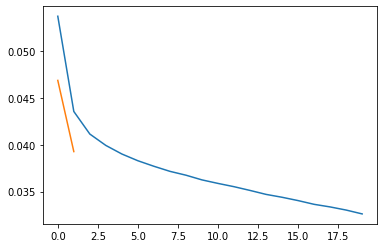

Running epoch: 0
epoch: 19 train avg. loss: 0.03622113
epoch: 19 test loss: 0.04414121
Total Model Training Runtime: 70.00000000 mins


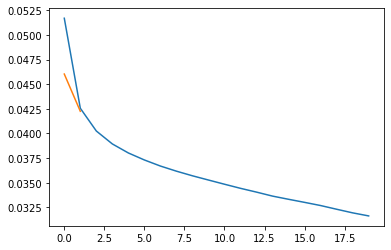

Running epoch: 0
epoch: 19 train avg. loss: 0.03711408
epoch: 19 test loss: 0.04640045
Total Model Training Runtime: 70.00000000 mins


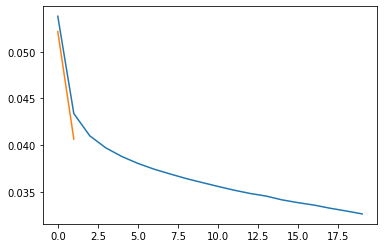

Running epoch: 0
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epo

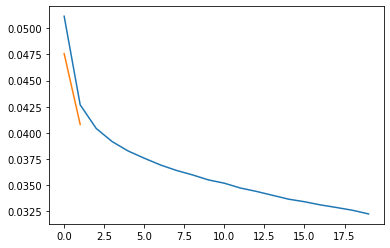

Running epoch: 0
epoch: 19 train avg. loss: 0.03629038
epoch: 19 test loss: 0.04344641
Total Model Training Runtime: 68.00000000 mins


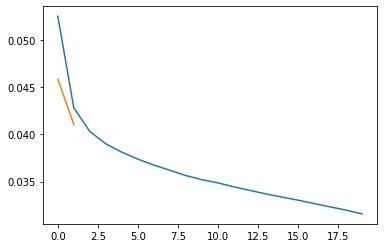

Running epoch: 0
epoch: 19 train avg. loss: 0.03686135
epoch: 19 test loss: 0.04379558
Total Model Training Runtime: 68.00000000 mins


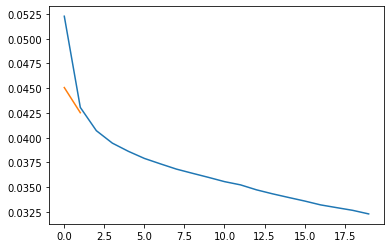

Running epoch: 0
epoch: 19 train avg. loss: 0.03646838
epoch: 19 test loss: 0.04659959
Total Model Training Runtime: 68.00000000 mins


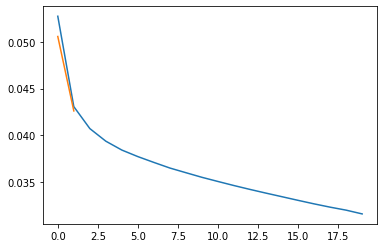

Running epoch: 0
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epo

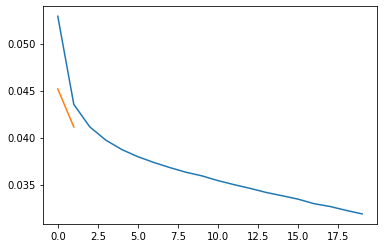

Running epoch: 0
epoch: 19 train avg. loss: 0.03786249
epoch: 19 test loss: 0.04306322
Total Model Training Runtime: 67.00000000 mins


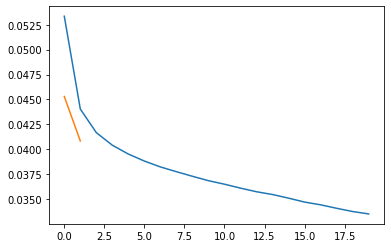

Running epoch: 0
epoch: 19 train avg. loss: 0.03750126
epoch: 19 test loss: 0.04298524
Total Model Training Runtime: 67.00000000 mins


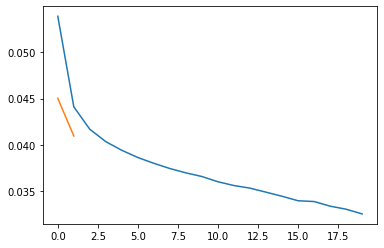

Running epoch: 0
epoch: 19 train avg. loss: 0.03749089
epoch: 19 test loss: 0.04198043
Total Model Training Runtime: 67.00000000 mins


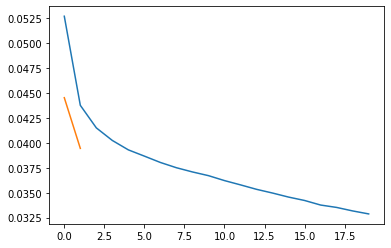

Running epoch: 0
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epo

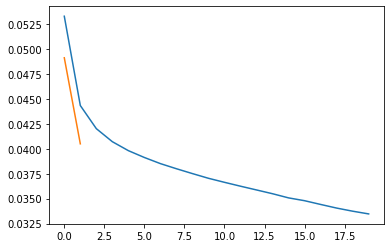

Running epoch: 0
epoch: 19 train avg. loss: 0.03619316
epoch: 19 test loss: 0.04301519
Total Model Training Runtime: 67.00000000 mins


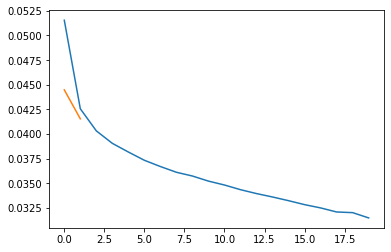

Running epoch: 0
epoch: 19 train avg. loss: 0.03777989
epoch: 19 test loss: 0.04472906
Total Model Training Runtime: 67.00000000 mins


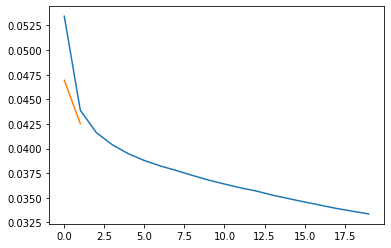

Running epoch: 0
epoch: 19 train avg. loss: 0.03713948
epoch: 19 test loss: 0.04269124
Total Model Training Runtime: 67.00000000 mins


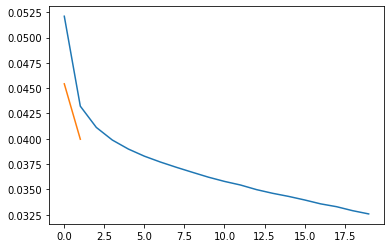

Running epoch: 0
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epo

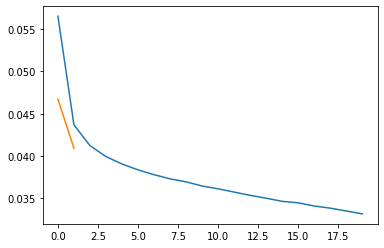

Running epoch: 0
epoch: 19 train avg. loss: 0.03808979
epoch: 19 test loss: 0.04241681
Total Model Training Runtime: 67.00000000 mins


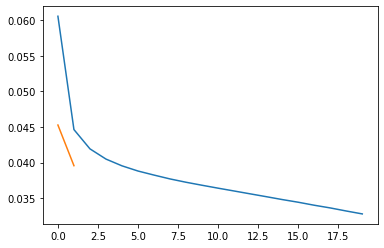

Running epoch: 0
epoch: 19 train avg. loss: 0.03676467
epoch: 19 test loss: 0.04165393
Total Model Training Runtime: 67.00000000 mins


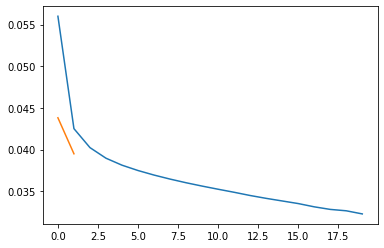

Running epoch: 0
epoch: 19 train avg. loss: 0.03843411
epoch: 19 test loss: 0.04159855
Total Model Training Runtime: 67.00000000 mins


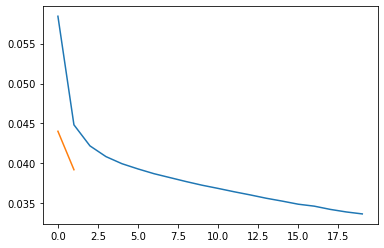

Running epoch: 0
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epo

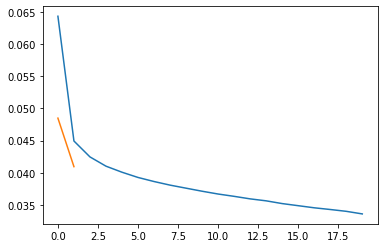

Running epoch: 0
epoch: 19 train avg. loss: 0.03721099
epoch: 19 test loss: 0.04374868
Total Model Training Runtime: 62.00000000 mins


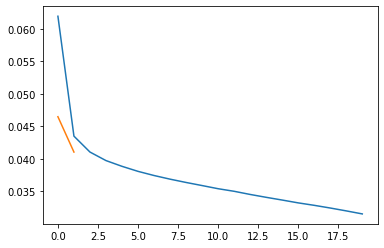

Running epoch: 0
epoch: 19 train avg. loss: 0.03831362
epoch: 19 test loss: 0.04197156
Total Model Training Runtime: 62.00000000 mins


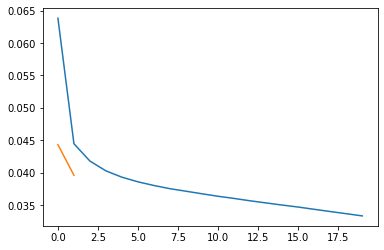

Running epoch: 0
epoch: 19 train avg. loss: 0.03862968
epoch: 19 test loss: 0.04231568
Total Model Training Runtime: 62.00000000 mins


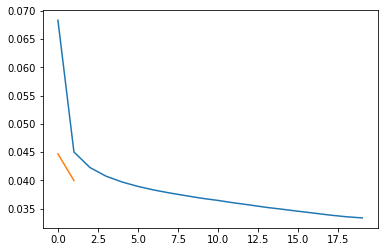

Running epoch: 0
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epo

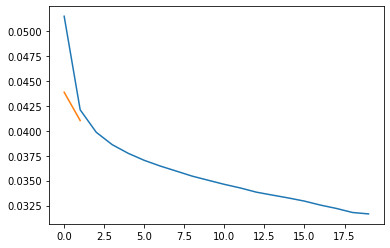

Running epoch: 0
epoch: 19 train avg. loss: 0.03656246
epoch: 19 test loss: 0.04315826
Total Model Training Runtime: 61.00000000 mins


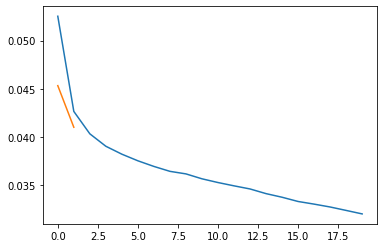

Running epoch: 0
epoch: 19 train avg. loss: 0.03647920
epoch: 19 test loss: 0.04230807
Total Model Training Runtime: 61.00000000 mins


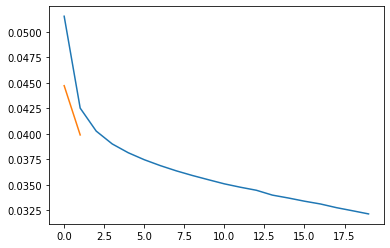

Running epoch: 0
epoch: 19 train avg. loss: 0.03674039
epoch: 19 test loss: 0.04243627
Total Model Training Runtime: 61.00000000 mins


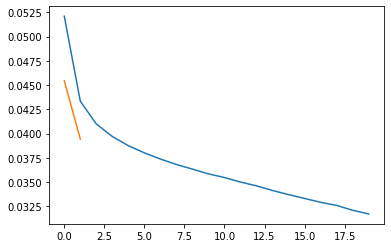

Running epoch: 0
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epo

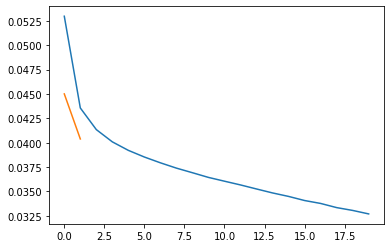

Running epoch: 0
epoch: 19 train avg. loss: 0.03835896
epoch: 19 test loss: 0.04220944
Total Model Training Runtime: 60.00000000 mins


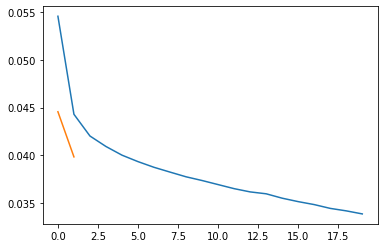

Running epoch: 0
epoch: 19 train avg. loss: 0.03680717
epoch: 19 test loss: 0.04204394
Total Model Training Runtime: 60.00000000 mins


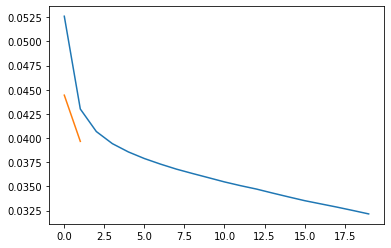

Running epoch: 0
epoch: 19 train avg. loss: 0.03827661
epoch: 19 test loss: 0.04287274
Total Model Training Runtime: 60.00000000 mins


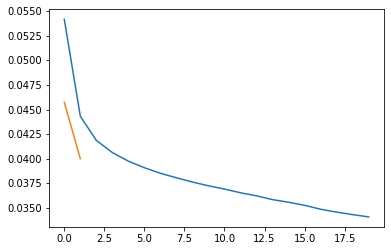

Running epoch: 0
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epo

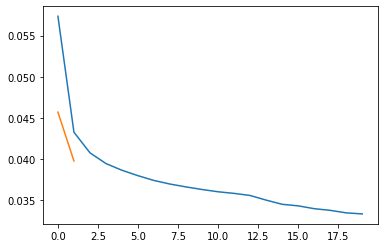

Running epoch: 0
epoch: 19 train avg. loss: 0.03837045
epoch: 19 test loss: 0.04281367
Total Model Training Runtime: 60.00000000 mins


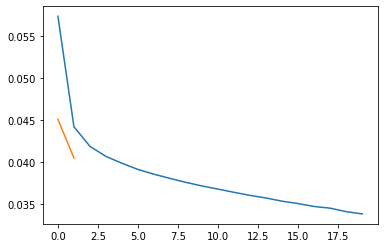

Running epoch: 0
epoch: 19 train avg. loss: 0.03786113
epoch: 19 test loss: 0.04277703
Total Model Training Runtime: 60.00000000 mins


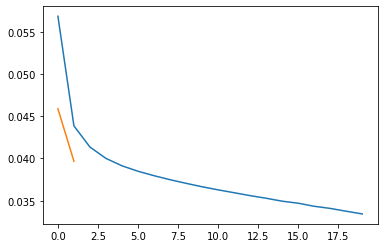

Running epoch: 0
epoch: 19 train avg. loss: 0.03761850
epoch: 19 test loss: 0.04344693
Total Model Training Runtime: 60.00000000 mins


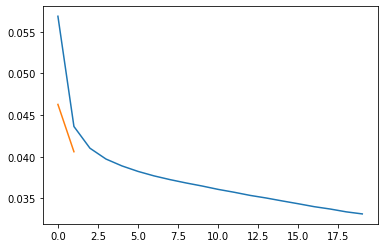

Running epoch: 0
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epo

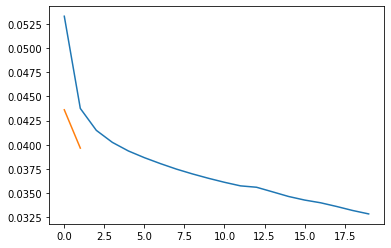

Running epoch: 0
epoch: 19 train avg. loss: 0.03765354
epoch: 19 test loss: 0.04259441
Total Model Training Runtime: 60.00000000 mins


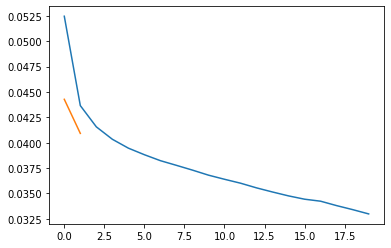

Running epoch: 0
epoch: 19 train avg. loss: 0.03592493
epoch: 19 test loss: 0.04248240
Total Model Training Runtime: 60.00000000 mins


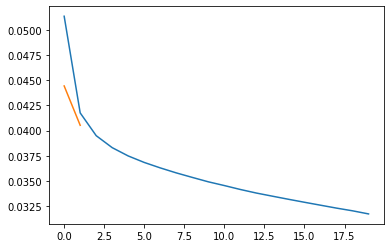

Running epoch: 0
epoch: 19 train avg. loss: 0.03674882
epoch: 19 test loss: 0.04467024
Total Model Training Runtime: 60.00000000 mins


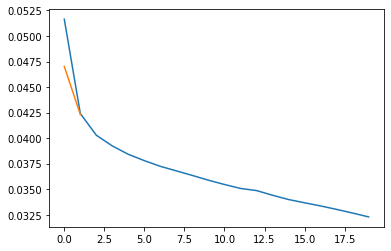

Running epoch: 0
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epo

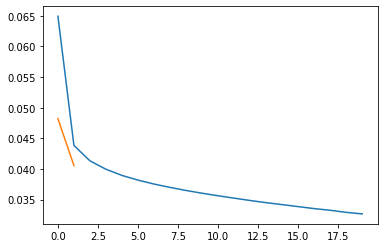

Running epoch: 0
epoch: 19 train avg. loss: 0.04008510
epoch: 19 test loss: 0.04376171
Total Model Training Runtime: 60.00000000 mins


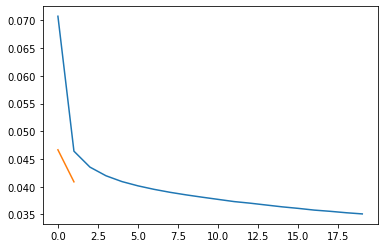

Running epoch: 0
epoch: 19 train avg. loss: 0.03780463
epoch: 19 test loss: 0.04528389
Total Model Training Runtime: 60.00000000 mins


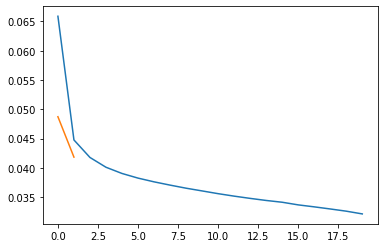

Running epoch: 0
epoch: 19 train avg. loss: 0.04032052
epoch: 19 test loss: 0.04254750
Total Model Training Runtime: 60.00000000 mins


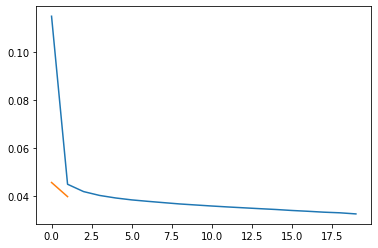

Running epoch: 0
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epo

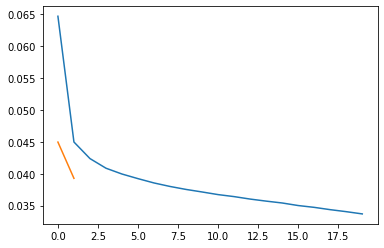

Running epoch: 0
epoch: 19 train avg. loss: 0.03884673
epoch: 19 test loss: 0.04275807
Total Model Training Runtime: 60.00000000 mins


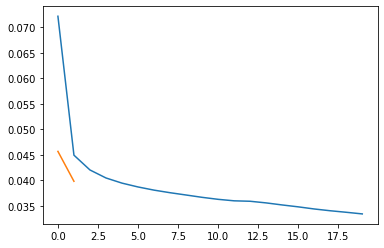

Running epoch: 0
epoch: 19 train avg. loss: 0.03864613
epoch: 19 test loss: 0.04242680
Total Model Training Runtime: 60.00000000 mins


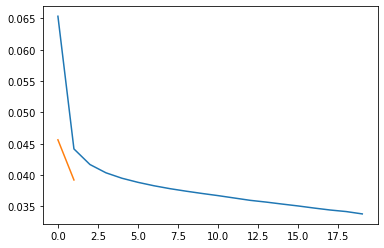

Running epoch: 0
epoch: 19 train avg. loss: 0.03731572
epoch: 19 test loss: 0.04208371
Total Model Training Runtime: 60.00000000 mins


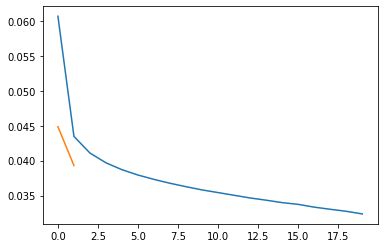

Running epoch: 0
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epo

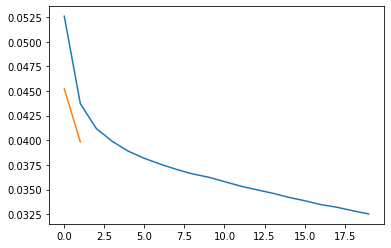

Running epoch: 0
epoch: 19 train avg. loss: 0.03761509
epoch: 19 test loss: 0.04353446
Total Model Training Runtime: 60.00000000 mins


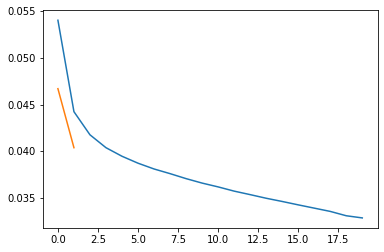

Running epoch: 0
epoch: 19 train avg. loss: 0.03770688
epoch: 19 test loss: 0.04363993
Total Model Training Runtime: 60.00000000 mins


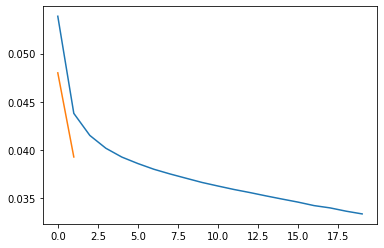

Running epoch: 0
epoch: 19 train avg. loss: 0.03665828
epoch: 19 test loss: 0.04370127
Total Model Training Runtime: 60.00000000 mins


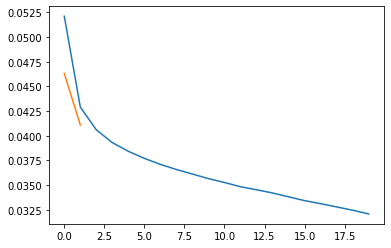

Running epoch: 0
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 1
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 2
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 3
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 4
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 5
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 6
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 7
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 8
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 9
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 10
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 11
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 12
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 13
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epoch: 14
Running epo

In [ ]:
input_size = X.shape[1]
output_size = 1
hidden_size = X.shape[1] * 2

# train model using bootstrap resampling
with Pool(processes=4) as pool:
    pool.starmap(bootstrap_training, [(train_idx, test_idx, i) \
                                      for i, (train_idx, test_idx) in enumerate(bootstrap)])

Running epoch: 0
Running epoch: 1
Running epoch: 2
Running epoch: 3
Running epoch: 4
Running epoch: 5
Running epoch: 6
Running epoch: 7
Running epoch: 8
Running epoch: 9
Running epoch: 10
Running epoch: 11
Running epoch: 12
Running epoch: 13
Running epoch: 14
Running epoch: 15
Running epoch: 16
Running epoch: 17
Running epoch: 18
Running epoch: 19
epoch: 19 train avg. loss: 0.03904668
epoch: 19 test loss: 0.04390261
Total Model Training Runtime: 29.00000000 mins


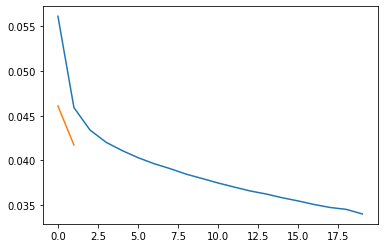

In [52]:
bootstrap_training(remaining[0], remaining[1], 76)

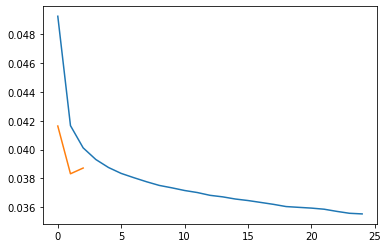

In [151]:
import matplotlib.pyplot as plt 

plt.Figure(figsize=(20,14))
plt.plot(trainer.train_loss)
plt.plot(trainer.test_loss)
plt.show()

In [83]:
import matplotlib.pyplot as plt 

def search_model():

    hidden_sizes = [X.shape[1] * 2, X.shape[1] * 3]
    lstm_layers = [2]
    lrs = np.linspace(1e-3, 2e-3, 5)

    counter = 1
    for lr in lrs:
        for hidden in hidden_sizes:
            for lstm in lstm_layers:
                print('learning rate: ', lr, ' hidden size: ', hidden, ' lstm layers: ', lstm)
                name = f'../models/scoring_lstm_checkpoint_v6_iter{counter}.pth'

                model = Model(input_size=X.shape[1], output_size=1, hidden_size=hidden, lstm_layers=lstm)

                trainer = Trainer(train_seq, train_target, test_seq, test_target, model, epochs=20, lr=lr) # best run: {'epochs' : 50, 'lr' : 50}
                trainer.train()

                torch.save(model.state_dict(), name)
                plt.Figure(figsize=(20,14))
                plt.plot(trainer.train_loss)
                plt.plot(trainer.test_loss)
                plt.show()
                
                counter +=1 

In [91]:
X.head()

forward        gp  gp_y_plus_1  draft_pick  is_drafted    height    weight  real_season_age  ...  next_yr_SJHL  next_yr_Slovakia  next_yr_SuperElit  next_yr_USDP  next_yr_USHL  next_yr_USHS-Prep  next_yr_VHL  next_yr_WHL
playerid player     season_age                                                                                               ...                                                                                                                            
200798   Nolan Reid  17.0           0.0  0.594595     0.704545         0.0         0.0  0.490196  0.342105             0.77  ...           0.0               0.0                0.0           0.0           0.0                0.0          0.0          1.0
                     18.0           0.0  0.837838     0.613636         0.0         0.0  0.490196  0.342105             0.77  ...           0.0               0.0                0.0           0.0           0.0                0.0          0.0          1.0
                     19.0           0.0  0.729730     0.704545         0.0         0.0  0.490196  0.342105             0.77  ...           0.0               0.0                0.0           0.0           0.0                0.0          0.0          1.0
                     20.0           0.0  0.837838     0.659091         0.0         0.0  0.490196  0.342105             0.77  ...           0.0               0.0                0.0           0.0           0.0                0.0          0.0          1.0
                    -1.0           -1.0 -1.000000    -1.000000        -1.0        -1.0 -1.000000 -1.000000            -1.00  ...          -1.0              -1.0               -1.0          -1.0          -1.0               -1.0         -1.0         -1.0

[5 rows x 84 columns]

learning rate:  0.001  hidden size:  168  lstm layers:  2
Running epoch: 0
Running epoch: 1
Running epoch: 2
Running epoch: 3
Running epoch: 4
Running epoch: 5
Running epoch: 6
Running epoch: 7
Running epoch: 8
Running epoch: 9
Running epoch: 10
Running epoch: 11
Running epoch: 12
Running epoch: 13
Running epoch: 14
Running epoch: 15
Running epoch: 16
Running epoch: 17
Running epoch: 18
Running epoch: 19
epoch: 19 train avg. loss: 0.04011370
epoch: 19 test loss: 0.04849122
Total Model Training Runtime: 69.00000000 mins


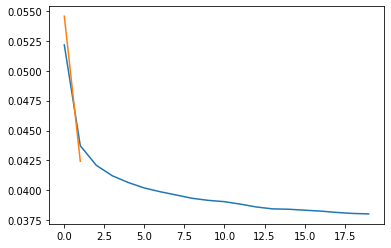

learning rate:  0.001  hidden size:  252  lstm layers:  2
Running epoch: 0
Running epoch: 1
Running epoch: 2
Running epoch: 3
Running epoch: 4
Running epoch: 5
Running epoch: 6
Running epoch: 7
Running epoch: 8
Running epoch: 9
Running epoch: 10
Running epoch: 11
Running epoch: 12
Running epoch: 13
Running epoch: 14
Running epoch: 15
Running epoch: 16
Running epoch: 17
Running epoch: 18
Running epoch: 19
epoch: 19 train avg. loss: 0.04023797
epoch: 19 test loss: 0.04841281
Total Model Training Runtime: 98.00000000 mins


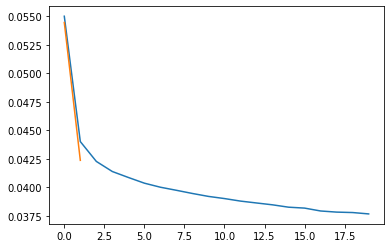

learning rate:  0.00125  hidden size:  168  lstm layers:  2
Running epoch: 0
Running epoch: 1
Running epoch: 2
Running epoch: 3
Running epoch: 4
Running epoch: 5
Running epoch: 6
Running epoch: 7
Running epoch: 8
Running epoch: 9
Running epoch: 10
Running epoch: 11
Running epoch: 12
Running epoch: 13
Running epoch: 14
Running epoch: 15
Running epoch: 16
Running epoch: 17
Running epoch: 18
Running epoch: 19
epoch: 19 train avg. loss: 0.04029650
epoch: 19 test loss: 0.04874500
Total Model Training Runtime: 84.00000000 mins


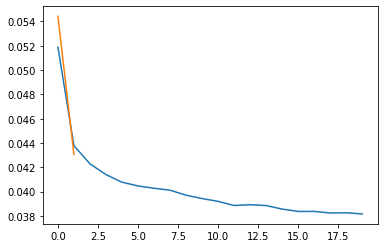

learning rate:  0.00125  hidden size:  252  lstm layers:  2
Running epoch: 0
Running epoch: 1
Running epoch: 2
Running epoch: 3
Running epoch: 4
Running epoch: 5
Running epoch: 6
Running epoch: 7
Running epoch: 8
Running epoch: 9
Running epoch: 10
Running epoch: 11
Running epoch: 12
Running epoch: 13
Running epoch: 14
Running epoch: 15
Running epoch: 16
Running epoch: 17
Running epoch: 18
Running epoch: 19
epoch: 19 train avg. loss: 0.04066733
epoch: 19 test loss: 0.04959982
Total Model Training Runtime: 110.00000000 mins


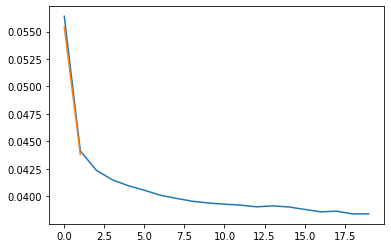

learning rate:  0.0015  hidden size:  168  lstm layers:  2
Running epoch: 0
Running epoch: 1
Running epoch: 2
Running epoch: 3
Running epoch: 4
Running epoch: 5
Running epoch: 6
Running epoch: 7
Running epoch: 8
Running epoch: 9
Running epoch: 10
Running epoch: 11
Running epoch: 12
Running epoch: 13
Running epoch: 14
Running epoch: 15
Running epoch: 16
Running epoch: 17
Running epoch: 18
Running epoch: 19
epoch: 19 train avg. loss: 0.04145893
epoch: 19 test loss: 0.05104256
Total Model Training Runtime: 81.00000000 mins


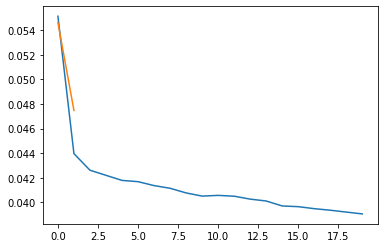

learning rate:  0.0015  hidden size:  252  lstm layers:  2
Running epoch: 0
Running epoch: 1
Running epoch: 2
Running epoch: 3
Running epoch: 4
Running epoch: 5
Running epoch: 6
Running epoch: 7
Running epoch: 8
Running epoch: 9
Running epoch: 10
Running epoch: 11
Running epoch: 12
Running epoch: 13
Running epoch: 14
Running epoch: 15
Running epoch: 16
Running epoch: 17
Running epoch: 18
Running epoch: 19
epoch: 19 train avg. loss: 0.04136659
epoch: 19 test loss: 0.05391454
Total Model Training Runtime: 100.00000000 mins


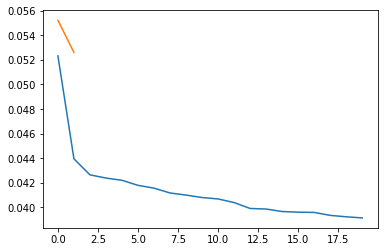

learning rate:  0.00175  hidden size:  168  lstm layers:  2
Running epoch: 0
Running epoch: 1
Running epoch: 2
Running epoch: 3
Running epoch: 4
Running epoch: 5
Running epoch: 6
Running epoch: 7
Running epoch: 8
Running epoch: 9
Running epoch: 10
Running epoch: 11
Running epoch: 12
Running epoch: 13
Running epoch: 14
Running epoch: 15
Running epoch: 16
Running epoch: 17
Running epoch: 18
Running epoch: 19
epoch: 19 train avg. loss: 0.04194048
epoch: 19 test loss: 0.05256117
Total Model Training Runtime: 73.00000000 mins


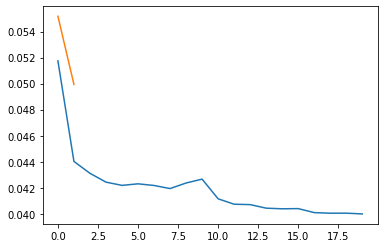

learning rate:  0.00175  hidden size:  252  lstm layers:  2
Running epoch: 0
Running epoch: 1
Running epoch: 2
Running epoch: 3
Running epoch: 4
Running epoch: 5
Running epoch: 6
Running epoch: 7
Running epoch: 8
Running epoch: 9
Running epoch: 10
Running epoch: 11
Running epoch: 12
Running epoch: 13
Running epoch: 14
Running epoch: 15
Running epoch: 16
Running epoch: 17
Running epoch: 18
Running epoch: 19
epoch: 19 train avg. loss: 0.04266531
epoch: 19 test loss: 0.05672322
Total Model Training Runtime: 100.00000000 mins


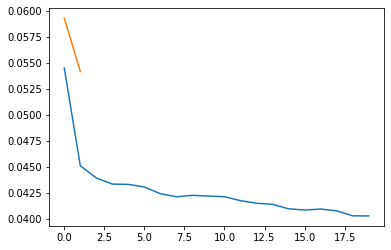

learning rate:  0.002  hidden size:  168  lstm layers:  2
Running epoch: 0
Running epoch: 1
Running epoch: 2
Running epoch: 3
Running epoch: 4
Running epoch: 5
Running epoch: 6
Running epoch: 7
Running epoch: 8
Running epoch: 9
Running epoch: 10
Running epoch: 11
Running epoch: 12
Running epoch: 13
Running epoch: 14
Running epoch: 15
Running epoch: 16
Running epoch: 17
Running epoch: 18
Running epoch: 19
epoch: 19 train avg. loss: 0.04216847
epoch: 19 test loss: 0.05445822
Total Model Training Runtime: 74.00000000 mins


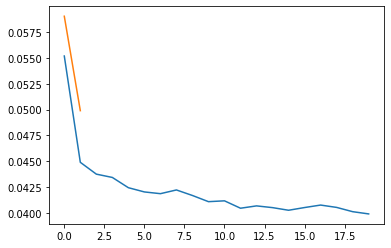

learning rate:  0.002  hidden size:  252  lstm layers:  2
Running epoch: 0
Running epoch: 1
Running epoch: 2
Running epoch: 3
Running epoch: 4
Running epoch: 5


KeyboardInterrupt: 

In [92]:
search_model()

learning rate:  0.001  hidden size:  148  lstm layers:  2
Running epoch: 0
Running epoch: 1
Running epoch: 2
Running epoch: 3
Running epoch: 4
Running epoch: 5
Running epoch: 6
Running epoch: 7
Running epoch: 8
Running epoch: 9
Running epoch: 10
Running epoch: 11
Running epoch: 12
Running epoch: 13
Running epoch: 14
Running epoch: 15
Running epoch: 16
Running epoch: 17
Running epoch: 18
Running epoch: 19
Running epoch: 20
Running epoch: 21
Running epoch: 22
Running epoch: 23
Running epoch: 24
Running epoch: 25
Running epoch: 26
Running epoch: 27
Running epoch: 28
Running epoch: 29
Running epoch: 30
Running epoch: 31
Running epoch: 32
Running epoch: 33
Running epoch: 34
Running epoch: 35
Running epoch: 36
Running epoch: 37
Running epoch: 38
Running epoch: 39
Running epoch: 40
Running epoch: 41
Running epoch: 42
Running epoch: 43
Running epoch: 44
Running epoch: 45
Running epoch: 46
Running epoch: 47
Running epoch: 48
Running epoch: 49
epoch: 49 train avg. loss: 0.02869012
epoch: 49 test

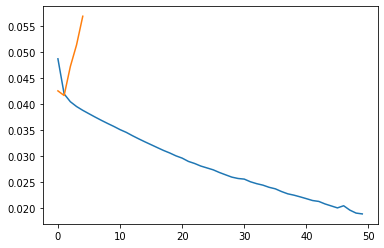

learning rate:  0.001  hidden size:  222  lstm layers:  2
Running epoch: 0
Running epoch: 1
Running epoch: 2
Running epoch: 3
Running epoch: 4
Running epoch: 5
Running epoch: 6
Running epoch: 7
Running epoch: 8
Running epoch: 9
Running epoch: 10
Running epoch: 11
Running epoch: 12
Running epoch: 13
Running epoch: 14
Running epoch: 15
Running epoch: 16
Running epoch: 17
Running epoch: 18
Running epoch: 19
Running epoch: 20
Running epoch: 21
Running epoch: 22
Running epoch: 23
Running epoch: 24
Running epoch: 25
Running epoch: 26
Running epoch: 27
Running epoch: 28
Running epoch: 29
Running epoch: 30
Running epoch: 31
Running epoch: 32
Running epoch: 33
Running epoch: 34
Running epoch: 35
Running epoch: 36
Running epoch: 37
Running epoch: 38
Running epoch: 39
Running epoch: 40
Running epoch: 41
Running epoch: 42
Running epoch: 43
Running epoch: 44
Running epoch: 45
Running epoch: 46
Running epoch: 47
Running epoch: 48
Running epoch: 49
epoch: 49 train avg. loss: 0.02819034
epoch: 49 test

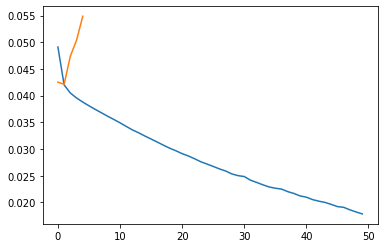

learning rate:  0.003  hidden size:  148  lstm layers:  2
Running epoch: 0
Running epoch: 1
Running epoch: 2
Running epoch: 3
Running epoch: 4
Running epoch: 5
Running epoch: 6
Running epoch: 7
Running epoch: 8
Running epoch: 9
Running epoch: 10
Running epoch: 11
Running epoch: 12
Running epoch: 13
Running epoch: 14
Running epoch: 15
Running epoch: 16
Running epoch: 17
Running epoch: 18
Running epoch: 19
Running epoch: 20
Running epoch: 21
Running epoch: 22
Running epoch: 23
Running epoch: 24
Running epoch: 25
Running epoch: 26
Running epoch: 27
Running epoch: 28
Running epoch: 29
Running epoch: 30
Running epoch: 31
Running epoch: 32
Running epoch: 33
Running epoch: 34
Running epoch: 35
Running epoch: 36
Running epoch: 37
Running epoch: 38
Running epoch: 39
Running epoch: 40
Running epoch: 41
Running epoch: 42
Running epoch: 43
Running epoch: 44
Running epoch: 45
Running epoch: 46
Running epoch: 47
Running epoch: 48
Running epoch: 49
epoch: 49 train avg. loss: 0.03324889
epoch: 49 test

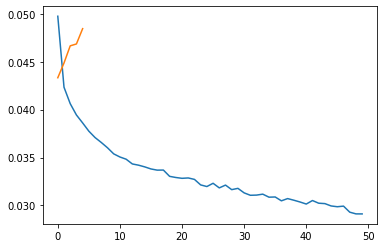

learning rate:  0.003  hidden size:  222  lstm layers:  2
Running epoch: 0
Running epoch: 1
Running epoch: 2
Running epoch: 3
Running epoch: 4
Running epoch: 5
Running epoch: 6
Running epoch: 7
Running epoch: 8
Running epoch: 9
Running epoch: 10
Running epoch: 11
Running epoch: 12
Running epoch: 13
Running epoch: 14
Running epoch: 15
Running epoch: 16
Running epoch: 17
Running epoch: 18
Running epoch: 19
Running epoch: 20
Running epoch: 21
Running epoch: 22
Running epoch: 23
Running epoch: 24
Running epoch: 25
Running epoch: 26
Running epoch: 27
Running epoch: 28
Running epoch: 29
Running epoch: 30
Running epoch: 31
Running epoch: 32
Running epoch: 33
Running epoch: 34
Running epoch: 35
Running epoch: 36
Running epoch: 37
Running epoch: 38
Running epoch: 39
Running epoch: 40
Running epoch: 41
Running epoch: 42
Running epoch: 43
Running epoch: 44
Running epoch: 45
Running epoch: 46
Running epoch: 47
Running epoch: 48
Running epoch: 49
epoch: 49 train avg. loss: 0.03347565
epoch: 49 test

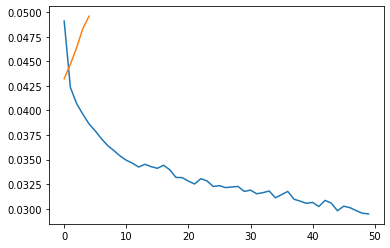

learning rate:  0.006  hidden size:  148  lstm layers:  2
Running epoch: 0
Running epoch: 1
Running epoch: 2
Running epoch: 3
Running epoch: 4
Running epoch: 5
Running epoch: 6
Running epoch: 7
Running epoch: 8
Running epoch: 9
Running epoch: 10
Running epoch: 11
Running epoch: 12
Running epoch: 13
Running epoch: 14
Running epoch: 15
Running epoch: 16
Running epoch: 17
Running epoch: 18
Running epoch: 19
Running epoch: 20
Running epoch: 21
Running epoch: 22
Running epoch: 23
Running epoch: 24
Running epoch: 25
Running epoch: 26
Running epoch: 27
Running epoch: 28
Running epoch: 29
Running epoch: 30
Running epoch: 31
Running epoch: 32
Running epoch: 33
Running epoch: 34
Running epoch: 35
Running epoch: 36
Running epoch: 37
Running epoch: 38
Running epoch: 39
Running epoch: 40
Running epoch: 41
Running epoch: 42
Running epoch: 43
Running epoch: 44
Running epoch: 45
Running epoch: 46
Running epoch: 47
Running epoch: 48
Running epoch: 49
epoch: 49 train avg. loss: 0.28177119
epoch: 49 test

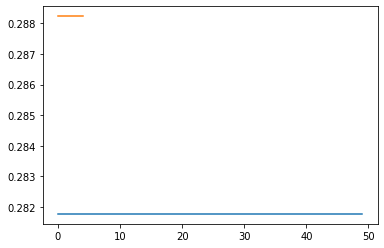

learning rate:  0.006  hidden size:  222  lstm layers:  2
Running epoch: 0
Running epoch: 1
Running epoch: 2
Running epoch: 3
Running epoch: 4
Running epoch: 5
Running epoch: 6
Running epoch: 7
Running epoch: 8
Running epoch: 9
Running epoch: 10
Running epoch: 11
Running epoch: 12
Running epoch: 13
Running epoch: 14
Running epoch: 15
Running epoch: 16
Running epoch: 17
Running epoch: 18
Running epoch: 19
Running epoch: 20
Running epoch: 21
Running epoch: 22
Running epoch: 23
Running epoch: 24
Running epoch: 25
Running epoch: 26
Running epoch: 27
Running epoch: 28
Running epoch: 29
Running epoch: 30
Running epoch: 31
Running epoch: 32
Running epoch: 33
Running epoch: 34
Running epoch: 35
Running epoch: 36
Running epoch: 37
Running epoch: 38
Running epoch: 39
Running epoch: 40
Running epoch: 41
Running epoch: 42
Running epoch: 43
Running epoch: 44
Running epoch: 45
Running epoch: 46
Running epoch: 47
Running epoch: 48
Running epoch: 49
epoch: 49 train avg. loss: 0.04036711
epoch: 49 test

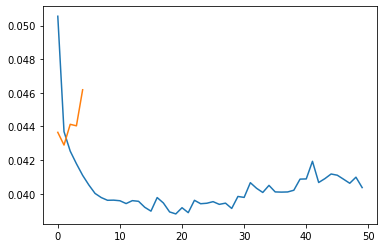

In [21]:
search_model()

### LSTM Model v1

In [ ]:
class Model(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, lstm_layers=2, output_size=1, drop=0.2):
        
        super().__init__()
        self.start = time.time()
        self.hidden_size = hidden_size
        self.lstm_layers = lstm_layers
        self.lstm = nn.LSTM(input_size, hidden_size, lstm_layers, batch_first=True,
#                             dropout=drop
                           )
        self.linear = nn.Linear(hidden_size, output_size)  
        self.relu = nn.ReLU()

    def forward(self, seasons):

        ht = torch.zeros(self.lstm_layers, 1, self.hidden_size)   # initialize hidden state
        ct = torch.zeros(self.lstm_layers, 1, self.hidden_size)  # initialize cell state
        predictions = torch.Tensor([]) # to store our predictions for season t+1
        
        hidden = (ht, ct)
        
        for idx, season in enumerate(seasons):  # here we want to iterate over the time dimension
            lstm_input = torch.FloatTensor(season).view(1,1,len(season)) # LSTM takes 3D tensor
            out, hidden = self.lstm(lstm_input, hidden) # LSTM updates hidden state and returns output
            pred_t = self.linear(out) # pass LSTM output through a linear activation function
            pred_t = self.relu(pred_t) # since performance is non-negative we apply ReLU
            
            predictions = torch.cat((predictions, pred_t)) # concatenate all the predictions

        return predictions

class Trainer(object):
    def __init__(self, train_sequences, train_targets, test_sequences, test_targets, model, epochs=200, lr=0.01, batch_size=1, log_per=10000):
        self.start = time.time()
        self.epochs = epochs
        self.log_per = log_per
        self.train_sequences = train_sequences
        self.train_targets = train_targets
        self.test_sequences = test_sequences
        self.test_targets = test_targets
        self.batch_size = batch_size
        self.lr = lr
        self.loss_fn = nn.MSELoss()
        self.model = model
        
    def train(self):

        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr,
#                                      weight_decay=1e-4
                                    )
        
        train_loss = []
        test_loss = []
        
        for ep in range(1, self.epochs):
            train_epoch_loss = []
            test_epoch_loss = []
            step = 0
            print(f'Running epoch: {ep}')
            for seasons, targets in zip(self.train_sequences, self.train_targets): # data is a list returning tuple of X, y
                step += 1
                optimizer.zero_grad()
                        
                mask = torch.tensor([(season > -1).all() for season in seasons]) # create mask for real seasons only      
                targets = torch.FloatTensor(targets)[mask]
                
                predictions = self.model(seasons)    
                # now here, we want to compute the loss between the predicted values
                # for each season and the actual values for each season
                # TO-DO: random select grouth truth or predicted value in next timestep
                loss = self.loss_fn(predictions[mask].squeeze(1), targets) 
                loss.backward()
                optimizer.step() 
                
                train_epoch_loss.append(loss.item())
            # validate with test set
            with torch.no_grad():

                for seasons, targets in zip(self.test_sequences, self.test_targets):
                    mask = torch.tensor([(season > -1).all() for season in seasons]) # create mask for real seasons only      
                    targets = torch.FloatTensor(targets)[mask]

                    predictions = self.model(seasons)    
                    # now here, we want to compute the loss between the predicted values
                    # for each season and the actual values for each season
                    # TO-DO: random select grouth truth or predicted value in next timestep
                    loss = self.loss_fn(predictions[mask].squeeze(1), targets) 

            
                    test_epoch_loss.append(loss.item())
                
            train_loss.append(np.nanmean(train_epoch_loss))
            test_loss.append(np.nanmean(test_epoch_loss))
            
            if ep%5 == 1:
                print(f'epoch: {ep:3} loss: {np.nanmean(train_epoch_loss):10.8f}')

        print(f'epoch: {ep:3} loss: {np.nanmean(train_epoch_loss):10.10f}')
        print(f'Total Model Training Runtime: {(time.time() - self.start)//60:10.8f} mins')
        self.train_loss = train_loss
        self.test_loss = test_loss   
        
input_size = X.shape[1]
output_size = 1
hidden_size = X.shape[1] * 2

model = Model(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# old trainer
trainer = Trainer(train_seq, train_target, test_seq, test_target, model, epochs=100, lr=0.0020117) # best run: {'epochs' : 50, 'lr' : 50}
trainer.train()

In [53]:
torch.save(model.state_dict(), '../models/scoring_lstm_checkpoint_v5.pth')

In [55]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
lstm.weight_ih_l0 	 torch.Size([592, 74])
lstm.weight_hh_l0 	 torch.Size([592, 148])
lstm.bias_ih_l0 	 torch.Size([592])
lstm.bias_hh_l0 	 torch.Size([592])
lstm.weight_ih_l1 	 torch.Size([592, 148])
lstm.weight_hh_l1 	 torch.Size([592, 148])
lstm.bias_ih_l1 	 torch.Size([592])
lstm.bias_hh_l1 	 torch.Size([592])
linear.weight 	 torch.Size([1, 148])
linear.bias 	 torch.Size([1])


### Evaluate Test Set

In [16]:
from generate_player_seasons import *

## Bootstrap model prediction

In [30]:
def get_boot_pred(seq):

    preds = []
    for i in range(100):
        preds.append(predict_scoring(seq, i)[:, -1, -1])

    return np.array([np.mean(s) for _, s in pd.DataFrame(preds).T.iterrows()])

In [31]:
test_preds = []
for seasons in test_seq: # data is a list returning tuple of X, y
    test_preds.append(get_boot_pred(seasons))

KeyboardInterrupt: 

In [ ]:
player_preds_test = []

for i, idx in enumerate(test_idx):
    df = pd.DataFrame(
        np.array([test_target[i][:,-1],
                  test_preds[i]]).T,
        columns=['y', 'y_pred'])

    player = pd.DataFrame([
        [i] for i in range(17, 25)],
        columns=['age'],
        index=pd.MultiIndex.from_tuples(
            [idx for i in range(17, 25)],
            names=['playerid', 'player'])).reset_index()

    player = player.merge(df, left_index=True, right_index=True)
    
    player_preds_test.append(player)
    
player_preds_test = pd.concat(player_preds_test)

In [ ]:
player_preds_test['err'] = player_preds_test.y - player_preds_test.y_pred 

## Single Model

In [12]:
with torch.no_grad():
    test_preds = torch.Tensor([])  # to store our predictions for season t+1
    for seasons, targets in zip(test_seq, test_target): # data is a list returning tuple of X, y
        pred_t = model(seasons) # NOTE: THIS IS WHERE IT BREAKS
        test_preds = torch.cat((test_preds, pred_t))
        
player_preds_test = []

for i, idx in enumerate(test_idx):
    df = pd.DataFrame(
        np.array([test_target[i][:,-1],
                  test_preds.detach().numpy()[(i) * 8: (i+1) * 8,-1,-1]]).T,
        columns=['y', 'y_pred'])

    player = pd.DataFrame([
        [i] for i in range(17, 25)],
        columns=['age'],
        index=pd.MultiIndex.from_tuples(
            [idx for i in range(17, 25)],
            names=['playerid', 'player'])).reset_index()

    player = player.merge(df, left_index=True, right_index=True)
    
    player_preds_test.append(player)
    
player_preds_test = pd.concat(player_preds_test)

In [13]:
print('Mean Absolute Error: ', mean_absolute_error(player_preds_test[player_preds_test.y != -1].y,
                    player_preds_test[player_preds_test.y != -1].y_pred))

print('Mean Squared Error: ', mean_squared_error(player_preds_test[player_preds_test.y != -1].y,
                    player_preds_test[player_preds_test.y != -1].y_pred))

Mean Absolute Error:  0.15989842396083273
Mean Squared Error:  0.05152101755408053


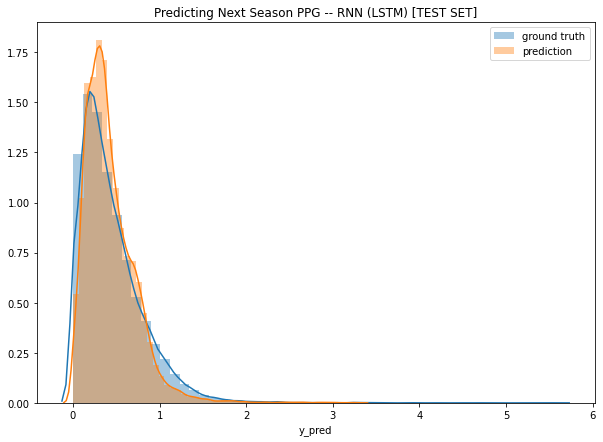

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
sns.distplot(player_preds_test[player_preds_test.y != -1].y, label='ground truth')
sns.distplot(player_preds_test[player_preds_test.y != -1].y_pred, label='prediction')
plt.legend()
plt.title('Predicting Next Season PPG -- RNN (LSTM) [TEST SET]')
plt.show()

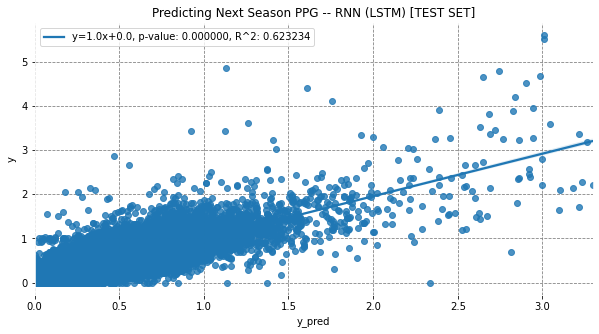

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.style as style

plt.rc('axes', facecolor='#ffffff', edgecolor='#ffffff',
       axisbelow=True, grid=True,
      )
plt.rc('grid', color='grey', linestyle='dashed')
plt.rc('patch', edgecolor='#ffffff', facecolor='#ffffff')

plt.figure(figsize=(10,5),facecolor="#ffffff")

slope, intercept, r_value, p_value, std_err = stats.linregress(player_preds_test[player_preds_test.y != -1].y_pred,
                                                               player_preds_test[player_preds_test.y != -1].y)

sns.regplot(data = player_preds_test[player_preds_test.y != -1], 
               x = 'y_pred',
                y = 'y',
               line_kws={'label':"y={0:.1f}x+{1:.1f}, p-value: {2:2f}, R^2: {3:2f}".format(slope,
                                                                                           intercept,
                                                                                           p_value, 
                                                                                           r_value ** 2)})
plt.title('Predicting Next Season PPG -- RNN (LSTM) [TEST SET]')
plt.legend()
plt.show()

In [16]:
player_preds_test[player_preds_test.player == 'Noah Hanifin']

,playerid,player,age,y,y_pred
0,177710,Noah Hanifin,17,0.604276,0.536595
1,177710,Noah Hanifin,18,0.305703,0.373551
2,177710,Noah Hanifin,19,0.384815,0.428089
3,177710,Noah Hanifin,20,0.404891,0.516215
4,177710,Noah Hanifin,21,0.405359,0.574629
5,177710,Noah Hanifin,22,0.314286,0.460520
6,177710,Noah Hanifin,23,-1.000000,0.545226
7,177710,Noah Hanifin,24,-1.000000,0.643388


In [17]:
player_preds_test[player_preds_test.player == 'Connor Jung']

,playerid,player,age,y,y_pred


### Predict on Train set

In [18]:
predictions = torch.Tensor([])  # to store our predictions for season t+1

for seasons, targets in zip(train_seq, train_target): # data is a list returning tuple of X, y

    pred_t = model(seasons) # NOTE: THIS IS WHERE IT BREAKS

    predictions = torch.cat((predictions, pred_t))

player_preds = []

In [19]:
for i, idx in enumerate(train_idx):
    df = pd.DataFrame(
        np.array([train_target[i][:,-1],
                  predictions.detach().numpy()[(i) * 8: (i+1) * 8,-1,-1]]).T,
        columns=['y', 'y_pred'])

    player = pd.DataFrame([
        [i] for i in range(17, 25)],
        columns=['age'],
        index=pd.MultiIndex.from_tuples(
            [idx for i in range(17, 25)],
            names=['playerid', 'player'])).reset_index()

    player = player.merge(df, left_index=True, right_index=True)
    
    player_preds.append(player)
    
player_preds = pd.concat(player_preds)

In [20]:
player_preds[player_preds.player == 'Cam Goldsmith']

,playerid,player,age,y,y_pred
0,369272,Cam Goldsmith,17,-1.000000,1.505473
1,369272,Cam Goldsmith,18,-1.000000,1.608631
2,369272,Cam Goldsmith,19,-1.000000,1.518689
3,369272,Cam Goldsmith,20,1.370463,0.512397
4,369272,Cam Goldsmith,21,0.987046,1.110648
5,369272,Cam Goldsmith,22,-1.000000,0.807745
6,369272,Cam Goldsmith,23,-1.000000,0.859483
7,369272,Cam Goldsmith,24,-1.000000,0.864801


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print('Mean Absolute Error: ', mean_absolute_error(player_preds[player_preds.y != -1].y,
                    player_preds[player_preds.y != -1].y_pred))

print('Mean Squared Error: ', mean_squared_error(player_preds[player_preds.y != -1].y,
                    player_preds[player_preds.y != -1].y_pred))

Mean Absolute Error:  0.15723976677018386
Mean Squared Error:  0.04911357761666917


In [169]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print('Mean Absolute Error: ', mean_absolute_error(player_preds[player_preds.y != -1].y,
                    player_preds[player_preds.y != -1].y_pred))

print('Mean Squared Error: ', mean_squared_error(player_preds[player_preds.y != -1].y,
                    player_preds[player_preds.y != -1].y_pred))

Mean Absolute Error:  0.14107263901208042
Mean Squared Error:  0.03539510584600935


In [22]:
player_preds[player_preds.player == 'Connor McDavid']

,playerid,player,age,y,y_pred
0,183442,Connor McDavid,17,2.754253,2.355807
1,183442,Connor McDavid,18,1.170935,1.310793
2,183442,Connor McDavid,19,1.310765,1.097875
3,183442,Connor McDavid,20,1.316513,1.216360
4,183442,Connor McDavid,21,1.461434,1.401993
5,183442,Connor McDavid,22,1.515625,1.460937
6,183442,Connor McDavid,23,-1.000000,0.496151
7,183442,Connor McDavid,24,-1.000000,0.602759


In [23]:
player_preds[player_preds.player == 'Brayden Point']

,playerid,player,age,y,y_pred


In [24]:
player_preds[player_preds.player == 'Nathan MacKinnon']

,playerid,player,age,y,y_pred
0,99204,Nathan MacKinnon,17,1.687792,1.503584
1,99204,Nathan MacKinnon,18,0.842496,0.760324
2,99204,Nathan MacKinnon,19,0.653283,0.868378
3,99204,Nathan MacKinnon,20,0.792821,0.790973
4,99204,Nathan MacKinnon,21,0.694706,0.935229
5,99204,Nathan MacKinnon,22,1.310253,0.965713
6,99204,Nathan MacKinnon,23,1.186417,1.326686
7,99204,Nathan MacKinnon,24,1.347826,1.338465


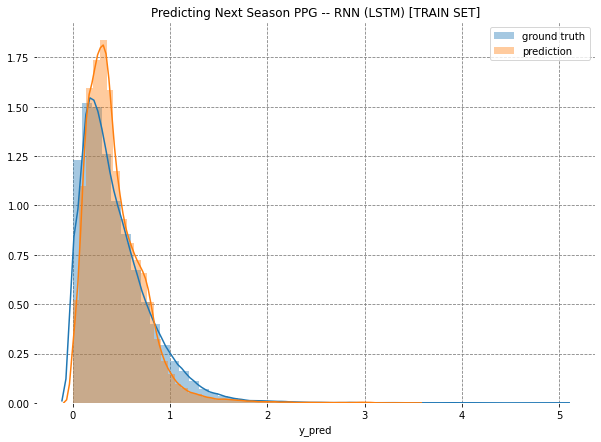

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
sns.distplot(player_preds[player_preds.y != -1].y, label='ground truth')
sns.distplot(player_preds[player_preds.y != -1].y_pred, label='prediction')
plt.legend()
plt.title('Predicting Next Season PPG -- RNN (LSTM) [TRAIN SET]')
plt.show()

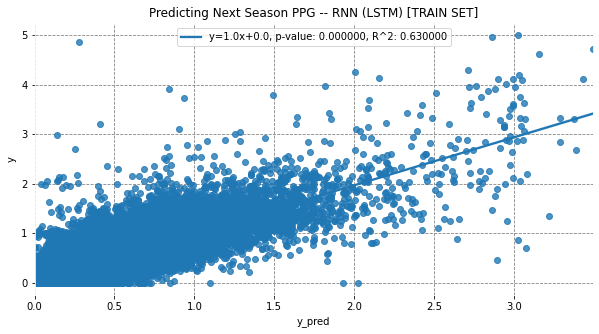

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.style as style

plt.rc('axes', facecolor='#ffffff', edgecolor='#ffffff',
       axisbelow=True, grid=True,
      )
plt.rc('grid', color='grey', linestyle='dashed')
plt.rc('patch', edgecolor='#ffffff', facecolor='#ffffff')

plt.figure(figsize=(10,5),facecolor="#ffffff")

slope, intercept, r_value, p_value, std_err = stats.linregress(player_preds[player_preds.y != -1].y_pred,
                                                               player_preds[player_preds.y != -1].y)

sns.regplot(data = player_preds[player_preds.y != -1], 
               x = 'y_pred',
                y = 'y',
               line_kws={'label':"y={0:.1f}x+{1:.1f}, p-value: {2:2f}, R^2: {3:2f}".format(slope,
                                                                                           intercept,
                                                                                           p_value, 
                                                                                           round(r_value ** 2, 2))})
plt.title('Predicting Next Season PPG -- RNN (LSTM) [TRAIN SET]')
plt.legend()
plt.show()

### LSTM + MLP

In [44]:
class TwoLayerMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.fc1(x)
        x2 = self.fc2(x1)

        return x2
    
class Model(nn.Module):
    def __init__(self, input_size=10, output_size=1, lstm_input_size=6, lstm_hidden_size=32, mlp_hidden_size=32, mlp_output_size=16):
        super().__init__()
        self.mlp = TwoLayerMLP(input_size, mlp_hidden_size, mlp_output_size)
        self.mlp_ = TwoLayerMLP(input_size + mlp_output_size, (input_size + mlp_output_size) * 2 , mlp_output_size)
        self.cell = nn.LSTMCell(lstm_input_size, lstm_hidden_size)
        self.lstm = nn.LSTM(lstm_input_size, lstm_hidden_size, batch_first=True)
        self.linear = nn.Linear(lstm_hidden_size, output_size)
        self.relu = nn.ReLU()
  
    def forward(self, player_features, player_performance):

        input_size = player_features.size(-1)
        lstm_input_size = player_performance.size(-1)
        seasons = player_features.size(1)
        preds = torch.Tensor([])

        # initialize lstm cell hidden state as a fn of the player features
        # i.e. we make our computation conditioned on player features
        for s in range(seasons):
            if s == 0:
                ht = self.mlp(player_features[: ,s ,:].view(1, 1 , input_size))  
                ct = torch.zeros_like(ht)
            else:
                ht = self.mlp_(torch.cat([ht.view(1, 1 , ht.size(-1)), player_features[: ,s ,:].view(1, 1 , input_size)], dim=-1))
#                 ct = self.mlp_(torch.cat([ct.view(1, 1 , ct.size(-1)), player_features[: ,s ,:].view(1, 1 , input_size)], dim=-1))
                
            ht, ct = self.cell(player_performance[: ,s ,:].view(1, 1, lstm_input_size).squeeze(1), (ht.squeeze(1), ct.squeeze(1)))
            pred_t = self.linear(ht)
            preds = torch.cat((preds, pred_t), 1)  # concat on the time dim

        return preds
    
class Trainer(object):
    def __init__(self, data, model, epochs=200, lr=0.001, batch_size=1, log_per=1000):
        self.epochs = epochs
        self.log_per = log_per
        self.data = data
        self.batch_size = batch_size
        self.lr = lr
        self.loss_fn = nn.MSELoss()
        self.model = model

    def train(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        steps = 0
        for ep in range(self.epochs):
            dataloader = DataLoader(self.data, shuffle=True, batch_size=self.batch_size)
            losses = []
            for idx, batch in enumerate(dataloader):
                batch_features = batch["state"]
                batch_performance = batch["performance"]
                batch_targets = batch["target"]
                preds = self.model(batch_features, batch_performance)
                
                loss = self.loss_fn(preds, batch_targets)
                loss.backward()
                optimizer.step()

                losses.append(loss)
                steps += 1
                if steps % self.log_per == 0:
                    print("steps {:d}, loss: {}".format(steps, loss))
#                     print("Ground Truth: {} \n\n Prediction: {}\n\n".format(batch_targets, preds))
        self.losses = losses

In [45]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [46]:
class PlayerDataset(Dataset):
    
    def __init__(self, target='ppg_y_plus_1'):
        super().__init__()
        self.df = pd.read_csv('player_season_stats.csv') # raw data
        self.X, self.X_, self.y = self.prepare_features(self.df, target) # prepare X, y splits
        self.players = self.X.index.droplevel(-1).unique() # get number indices
        self.n_players = self.players.shape[0] # get number of players
        self.train_idx, self.test_idx = train_test_split(self.players, test_size=0.2, random_state=42)
        
        self.init_players()
    
    def prepare_features(self, df, target):

        dummies = list(set(['league_y_plus_1']) - set([target]))

        features = ['forward', 'gp', 'gp_y_plus_1',
                     'draft_pick', 'is_drafted', 
                     'height', 'weight', 'real_season_age']

        performance_feats = ['gpg', 'apg', 'ppg', 'perc_team_g',
                             'perc_team_a', 'perc_team_tp']

        df = get_next_season_data(df)

        df = df[(df.gp_y_plus_1.notnull()
                 & (df.season_age >= 17)
                 & (df.season_age <= 23))]

        df = is_drafted(df)
        df = draft_position(df)
        df['forward'] = df.position.apply(is_forward)
        df['real_season_age'] = df['real_season_age'] - df['season_age'] # scale age based on birthday

        df.set_index(['playerid', 'player', 'season_age'], inplace=True)

        start_league = pd.get_dummies(df.league, drop_first=True)
        next_season_league = pd.get_dummies(
            df[dummies], drop_first=True, prefix='next_yr')
        draft_round = pd.get_dummies(
            df.draft_round,  drop_first=True, prefix='round')

        X = df[features] # base categorical features
        X_ = df[performance_feats] # performance metric features
        
        # feature scaling
        scaler = MinMaxScaler()
        X[X.columns] = scaler.fit_transform(X)
        X_[X_.columns] = scaler.fit_transform(X_)
        
        y = df[target]
        X = X.merge(start_league, left_index=True, right_index=True)\
            .merge(next_season_league, left_index=True, right_index=True)\
            .merge(draft_round, left_index=True, right_index=True)

        return X, X_, y
        
    def generate_data(self, X, X_, y, indices):

        sequences = []

        for idx in indices:

            sequences.append(
                {
                    'state' : torch.FloatTensor(X.loc[idx].values),
                    'performance' : torch.FloatTensor(X_.loc[idx].values),
                    'target' : torch.FloatTensor(y.loc[idx].values)
                }
            )

        return sequences
    
    def init_players(self):

        self.train_seq = self.generate_data(self.X, self.X_, self.y, self.players)
  
    def __getitem__(self, idx):
        return self.train_seq[idx]
  
    def __len__(self):
        return len(self.train_seq)


In [47]:
data = PlayerDataset()


In [48]:
model = Model(input_size=61, 
              output_size=1, 
              lstm_input_size=6, 
              lstm_hidden_size=16, 
              mlp_hidden_size=32,
              mlp_output_size=16)

trainer = Trainer(data, model)
trainer.train()

steps 1000, loss: 0.04304332658648491
steps 2000, loss: nan
steps 3000, loss: nan
steps 4000, loss: nan
steps 5000, loss: nan
steps 6000, loss: nan
steps 7000, loss: nan
steps 8000, loss: nan
steps 9000, loss: nan
steps 10000, loss: nan
steps 11000, loss: nan
steps 12000, loss: nan
steps 13000, loss: nan
steps 14000, loss: nan
steps 15000, loss: nan
steps 16000, loss: nan
steps 17000, loss: nan
steps 18000, loss: nan
steps 19000, loss: nan
steps 20000, loss: nan
steps 21000, loss: nan
steps 22000, loss: nan
steps 23000, loss: nan
steps 24000, loss: nan
steps 25000, loss: nan
steps 26000, loss: nan
steps 27000, loss: nan
steps 28000, loss: nan
steps 29000, loss: nan
steps 30000, loss: nan
steps 31000, loss: nan
steps 32000, loss: nan
steps 33000, loss: nan
steps 34000, loss: nan
steps 35000, loss: nan
steps 36000, loss: nan
steps 37000, loss: nan
steps 38000, loss: nan
steps 39000, loss: nan
steps 40000, loss: nan
steps 41000, loss: nan
steps 42000, loss: nan
steps 43000, loss: nan


KeyboardInterrupt: 

In [420]:
data.train_seq[0]

{'state': tensor([[0.0000, 0.2096, 0.2059, 0.0000, 0.0000, 0.5000, 0.4474, 0.9200, 0.0000,
          0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.2096, 0.3176, 0.0000, 0.0000, 0.5000, 0.4474, 0.9200, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
          0.0000, 0.00

### Comparing xgboost and RNN

In [41]:
pd.set_option('max_columns', 100)

In [56]:
baseline_preds[baseline_preds.player=='Mitchell Marner']

NameError: name 'baseline_preds' is not defined

In [57]:
X.loc[(62204)]

forward        gp  gp_y_plus_1  draft_pick  is_drafted  height  ...  next_yr_SHL  next_yr_SJHL  next_yr_SuperElit  next_yr_USHL  next_yr_VHL  next_yr_WHL
player        season_age                                                                  ...                                                                                      
Brayden Point  17.0           1.0  0.770270     0.704545    0.000000         0.0    0.46  ...          0.0           0.0                0.0           0.0          0.0          1.0
               18.0           1.0  0.837838     0.568182    0.000000         0.0    0.46  ...          0.0           0.0                0.0           0.0          0.0          1.0
               19.0           1.0  0.675676     0.431818    0.271478         1.0    0.46  ...          0.0           0.0                0.0           0.0          0.0          1.0
               20.0           1.0  0.513514     0.659091    0.271478         1.0    0.46  ...          0.0           0.0                0.0           0.0          0.0          0.0
               21.0           1.0  0.783784     0.818182    0.271478         1.0    0.46  ...          0.0           0.0                0.0           0.0          0.0          0.0
               22.0           1.0  0.972973     0.784091    0.271478         1.0    0.46  ...          0.0           0.0                0.0           0.0          0.0          0.0
               23.0           1.0  0.932432     0.636364    0.271478         1.0    0.46  ...          0.0           0.0                0.0           0.0          0.0          0.0
              -1.0           -1.0 -1.000000    -1.000000   -1.000000        -1.0   -1.00  ...         -1.0          -1.0               -1.0          -1.0         -1.0         -1.0

[8 rows x 74 columns]

In [63]:
sorted(leagues)[1:]

['AJHL',
 'Allsvenskan',
 'BCHL',
 'CCHL',
 'Czech',
 'Czech2',
 'Jr. A SM-liiga',
 'KHL',
 'Liiga',
 'MHL',
 'NCAA',
 'NHL',
 'NLA',
 'OHL',
 'OJHL',
 'QMJHL',
 'SHL',
 'SJHL',
 'SuperElit',
 'USHL',
 'VHL',
 'WHL']

In [94]:
pd.pivot_table(data=X.loc[(X.next_yr_NCAA == 1), sorted(leagues)[1:]].idxmax(axis=1).to_frame(),
               columns=sorted(leagues)[1:],
              aggfunc='count')

Empty DataFrame
Columns: []
Index: []

In [95]:
import collections
collections.Counter(X.loc[(X.next_yr_NCAA == 1), sorted(leagues)[1:]].idxmax(axis=1))

Counter({'BCHL': 737,
         'NCAA': 11848,
         'USHL': 1875,
         'AJHL': 315,
         'OJHL': 218,
         'CCHL': 131,
         'Jr. A SM-liiga': 18,
         'SuperElit': 27,
         'SJHL': 68,
         'MHL': 2})

In [81]:
pd.pivot_table?